# Introduction to Machine Learning - Project
**Sahar Mahavy and Omri Shmueli (Group #40)**

# Setup- Imports and Warning Ignore

In [1]:
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import auc, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Reusable Functions

In [3]:
#Functions:
def sum_up_durations(chosen_duration, df): 
    # Sum up durations with only one NA in durations because they need to be added up to the same value
    duration_lst = ['total_duration' , 'admin_page_duration' , 'info_page_duration' , 'product_page_duration']
    duration_lst.remove(chosen_duration)
    mask = ((df[chosen_duration].isna()) & (df[duration_lst[0]].notna()) & (df[duration_lst[1]].notna()) & (df[duration_lst[2]].notna()))
    if (chosen_duration == 'total_duration'):
        df.loc[mask, chosen_duration] = df[mask][duration_lst].sum(axis=1)
    else :
        df.loc[mask, chosen_duration] = df[mask]['total_duration'] - df[mask][duration_lst[1:]].sum(axis=1)
        
def fill_na_duration_by_pages(chosen_duration, chosen_page, df_source,df_target):
    # Fill NA of durations using the median of each duration for a specific page
    mask = df_target[chosen_duration].isna()
    x = np.array(df_source[chosen_page])
    x = x[~np.isnan(x)]
    x = list(set(x))
    for elem in x:
        df_target.loc[mask & (df_target[chosen_page] == elem), chosen_duration] = np.nanmedian(df_source[(df_source[chosen_page] == elem)][chosen_duration])

def fill_na_pages_by_duration(chosen_duration, chosen_page, df_source, df_target):
    # Fill NA of pages using manipulation on the median of each duration for a specific page
    sub = df_source[(df_source[chosen_page].notna()) & (df_source[chosen_page] != 0) \
    & (df_source[chosen_duration].notna()) & (df_source[chosen_duration] != 0)] 
    avg_page = sub[chosen_duration] / sub[chosen_page]
    median_page = np.median(avg_page)
    df_target.loc[(df_target[chosen_page].isna()) & (df_target[chosen_duration].notna()), chosen_page] = np.ceil(df_target[chosen_duration] / median_page)

def outliers_handling(feature,p, df_source, df_target):
    # Replacing outliers value using specified percentile
    values = np.array(df_source[feature])
    threshold = np.percentile(values, q= p)
    print("The number of values that has changed: ", len(df_target[df_target[feature] > threshold]))
    df_target.loc[df_target[feature] > threshold, feature] = threshold

def scores_over_lambda(Cs,scores,chosen_c):
    # Plot scores of the model over hyperparameter and extract the best one
    plt.plot(Cs, scores)
    plt.xlabel('Cs')
    plt.ylabel('accuracy score')
    plt.title("accuracy measure over different lambda's")
    plt.show()
    C_opt_lr = chosen_c
    lambda_opt_lr = 1/chosen_c
    print("The optimal lambda is: ",lambda_opt_lr,
    "\n( Best C:", C_opt_lr, ")")
    return C_opt_lr, lambda_opt_lr

def normalize_columns(col,data):
    # Normalize given columns between 0 - 1 relative to the origin
    # Given the data and a list of columns
    for c in col:
        sum = data[c].sum(axis=0)
        data[c] = data[c].divide(sum, axis=0)

def plot_roc_kfold(clf,cv,X,y,feat,giventitle):
    # Plot roc curve for each k of the folds given in the cv argument
    # Returns the mean tpr and fpr for comparison purposes
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10,7))
    for i, (train, test) in enumerate(cv.split(X[feat], y)):
        clf.fit(X[feat].iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            clf,
            X[feat].iloc[test],
            y.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.3f $\pm$ %0.4f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=giventitle,
    )

    ax.legend(loc="lower right")
    plt.show()

    return mean_tpr, mean_fpr


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            sensitivity    = cf[1,1] / sum(cf[1,:])
            specificity = cf[0,0] / sum(cf[0,:])
            f1_score  = 2*precision*sensitivity / (precision + sensitivity)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nSensitivity={:0.3f}\nSpecificity={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,sensitivity,specificity,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


# Exploration and Visualizations

Reading the data and taking a first glance

In [4]:
data = pd.read_csv("train.csv")
data.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


In [5]:
data.dtypes

id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
purchase                   int64
dtype: object

We have noticed that columns that represent numeric values are from a general "object" type. ("0.0 minutes" etc.)<br>
We figured we should convert those columns to float type.

In [6]:
data["info_page_duration"] = data["info_page_duration"].replace("minutes", "", regex=True).astype("float64")
data["product_page_duration"] = data["product_page_duration"].replace("minutes", "", regex=True).astype("float64")

Examining missing values

In [7]:
data.isnull().sum()


id                           0
num_of_admin_pages         605
admin_page_duration        413
num_of_info_pages          687
info_page_duration         317
num_of_product_pages       403
product_page_duration      621
total_duration            4753
BounceRates                 22
ExitRates                   26
PageValues                  27
closeness_to_holiday       496
Month                       25
device                     323
internet_browser           563
Region                      19
user_type                   23
Weekend                     23
A                          706
B                           23
C                           23
D                        10374
purchase                     0
dtype: int64

First visualization of data distributions to get basic intuitions.  


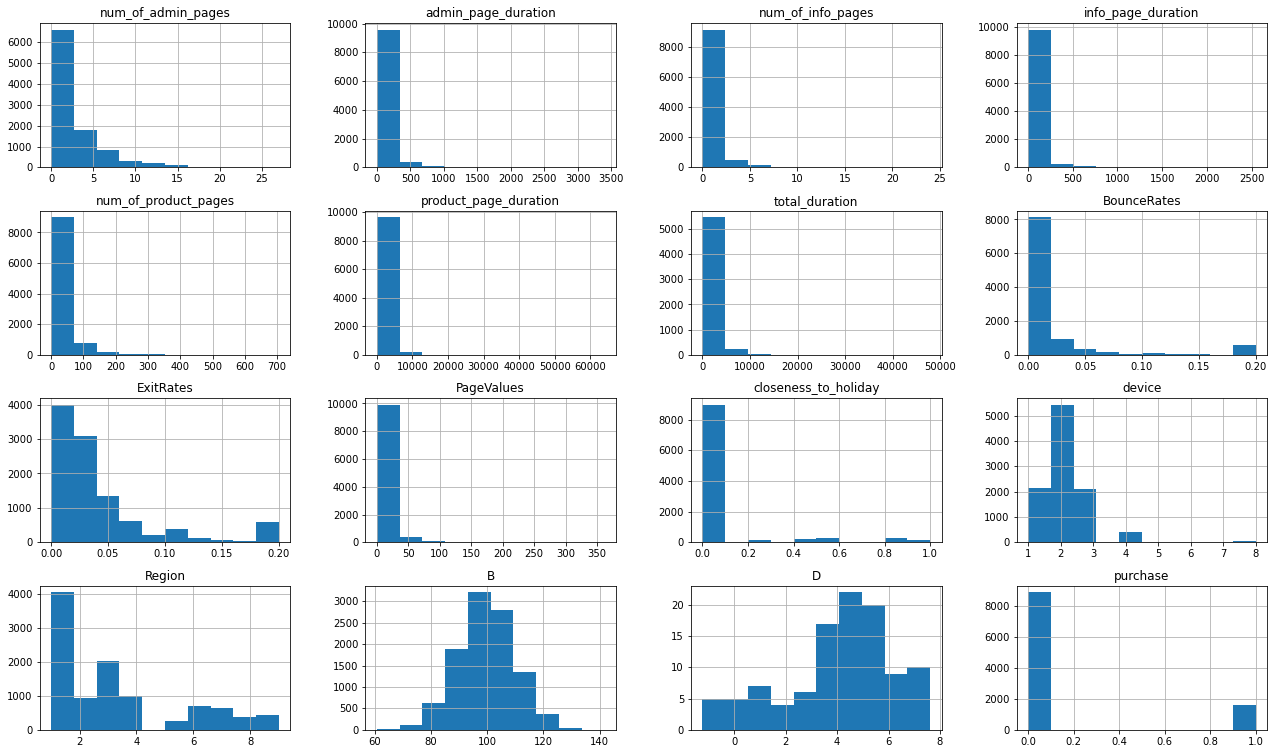

In [8]:
data.iloc[:,1:].hist(figsize=(22,13))
plt.show()

#### Now we would like to dive in to get a better understainding of specific features

In [9]:
print("Percentage of completed purchases: ", data['purchase'].sum()/len(data))

Percentage of completed purchases:  0.15469033304704646


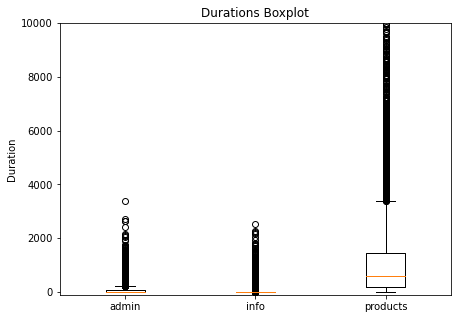

The upper whisker for admin is : 232.4
The upper whisker for info is : 0.0
The upper whisker for product is : 3400.248897
Mean of product pages:  1197.518515991718
Mean of admin pages:  80.46246840167895
count    10162.000000
mean        34.323813
std        142.039051
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: info_page_duration, dtype: float64


In [10]:
plt.figure(figsize=(7,5))
plt.ylim(-100,10000)
plt.ylabel('Duration')
admin_dur = data['admin_page_duration'].dropna()
info_dur = data['info_page_duration'].dropna()
product_dur = data['product_page_duration'].dropna()
durations = [admin_dur,info_dur,product_dur]
bp = plt.boxplot(durations)
plt.xticks(ticks=[1,2,3], labels=["admin", "info","products"])
plt.title("Durations Boxplot")
plt.show()
lst = [item.get_ydata()[1] for item in bp['whiskers']]
print("The upper whisker for admin is :" ,lst[1])
print("The upper whisker for info is :" ,lst[3])
print("The upper whisker for product is :" ,lst[5])
print("Mean of product pages: " ,np.mean(data['product_page_duration']))
print("Mean of admin pages: ", np.mean(data['admin_page_duration']))

print(data['info_page_duration'].describe())


Those features do not come from normal distribution but still we can tell from the plot that we have a lot of high values potentially being ouliers due to 'AFK' reasons when the sessions are left open. We can see the numeric values of the upper whiskers.
After seeing 0 for the upper whisker of info we wanted to see the full distribution of this feature.

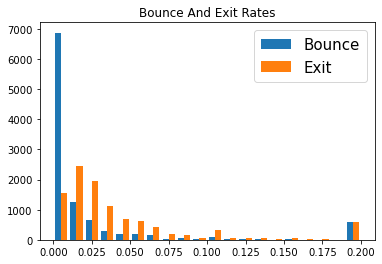

In [11]:
plt.hist(data[["BounceRates","ExitRates"]], bins= 20, label=['Bounce','Exit'])
plt.legend(fontsize=15, borderpad= 0.5)
plt.title("Bounce And Exit Rates")
plt.show()


Most sessions don't start with pages with Bounce rate at all. There is some correlation between the Bounce and Exit rate as expected. 
The most interesting insight we recieve from the plot is the phenomena that a respectful amount of sessions have the same value 0.2 for both features. We'll investigate it further.

In [12]:
data_bounce_exit_02 = data[(data["BounceRates"] == 0.2)& (data["ExitRates"] == 0.2)]
print("Number of sessions with 0.2 in Bounce and Exit rates: ", len(data_bounce_exit_02))
print(data_bounce_exit_02['total_duration'].describe())
print("Instances where total duration is greater than 0 when Bounce and Exit Rates are 0.2: ",len(data_bounce_exit_02[data_bounce_exit_02['total_duration'] > 0]))

Number of sessions with 0.2 in Bounce and Exit rates:  584
count    319.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: total_duration, dtype: float64
Instances where total duration is greater than 0 when Bounce and Exit Rates are 0.2:  0


After filtering the data to see only the sessions with Bounce and Exit rate 0.2 we understand that the majority of them indicates 0 total duration and must be some pop up pages that end with no purchase. It can even help us fill missing values.

PageValues is one of the most important features in respect to our theoretical knowledge.<br> We want to understand how it distributes and see how it reflects on the purchase value.<br> A good confirmation to our theory is the robust indicator for no purchase when the page value is 0.

In [13]:
print("Page Value statistic information:") 
print(data['PageValues'].describe())
pv_pos = len(data[(data['PageValues'] > 0) & (data['purchase']==1)]) / len(data[data['PageValues'] > 0])*100
pv_neg = len(data[(data['PageValues'] == 0) & (data['purchase']==0)]) / len(data[data['PageValues'] == 0])*100
print( "When the page value is positive "+str(pv_pos)+"% of sessions end with purchase" )
print( "When the page value is zero "+str(pv_neg)+"% of sessions end without purchase" )


Page Value statistic information:
count    10452.000000
mean         5.900387
std         18.727496
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64
When the page value is positive 56.482281763180644% of sessions end with purchase
When the page value is zero 96.2029982796756% of sessions end without purchase


Value count:
0.0    8958
0.6     290
0.8     266
0.4     199
0.2     147
1.0     123
Name: closeness_to_holiday, dtype: int64


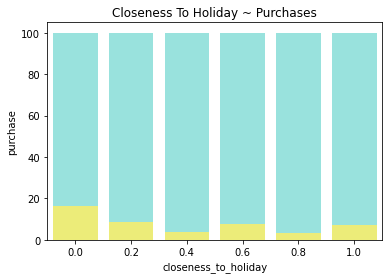

In [14]:
print("Value count:")
print(data['closeness_to_holiday'].value_counts())
purchases = data[['closeness_to_holiday','purchase']].dropna()
total = data.groupby('closeness_to_holiday')['purchase'].count().reset_index()
ones = data[(data["purchase"] ==1)].groupby('closeness_to_holiday')['purchase'].sum().reset_index()
ones ['purchase'] = [i / j * 100 for i,j in zip(ones ['purchase'], total['purchase'])]
total['purchase'] = [i / j * 100 for i,j in zip(total['purchase'], total['purchase'])]
bar1 = sns.barplot(x='closeness_to_holiday', y='purchase', data=total, color='#8DEEE7')
bar2 = sns.barplot(x='closeness_to_holiday', y='purchase', data=ones , color='#FFFF66')
plt.title("Closeness To Holiday ~ Purchases")
plt.show()


We expected to have more purchases close to holidays. Most sessions have not been made close to holiday and this is why we can't see it clearly, but we do see higher percentages of purchasing when the session is close to holiday like the difference between 0.4 and 1.

In [15]:
months = data["Month"].value_counts()
print("Traffic per month")
print(months.sort_index())


Traffic per month
Aug      365
Dec     1450
Feb      163
Jul      367
June     248
Mar     1615
May     2857
Nov     2539
Oct      471
Sep      379
Name: Month, dtype: int64


We see that every month has significantly different traffic of sessions and we want to examine the amount of purchases in relative to the traffic.

In [16]:
months_purchases = data[data['purchase'] == 1]['Month'].value_counts()
months_np = months.sort_index().to_numpy()
months_purchases_np = months_purchases.sort_index().to_numpy()
per = pd.DataFrame(months_purchases_np/months_np*100, index=months.sort_index().index)
print("Completed purchases per month in percentage")
per.rename(columns={0:'percentage %'}, inplace=True)
print(per)

Completed purchases per month in percentage
      percentage %
Aug      17.534247
Dec      12.965517
Feb       1.840491
Jul      14.713896
June     10.080645
Mar       9.969040
May      10.745537
Nov      25.364317
Oct      20.594480
Sep      19.525066


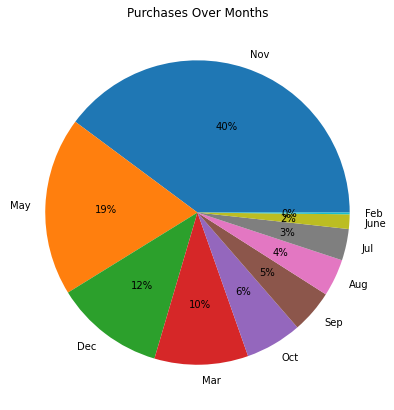

In [17]:
plt.figure(figsize=(7,7))
months_purchases.plot(kind="pie",autopct="%1.0f%%")
plt.ylabel("")
plt.title("Purchases Over Months")
plt.show()


The plot tells us how the purchases spread over the year. Most of them happen in November, May, December and March, correlates well with the holiday preparations.

In [18]:
dev = data["device"].value_counts()
print("Number of sessions per device:")
print(dev)
dev_purchases = data[data['purchase'] == 1]['device'].value_counts()
dev_np = dev.sort_index().to_numpy()
dev_purchases_np = dev_purchases.sort_index().to_numpy()
dev_per = pd.DataFrame(dev_purchases_np/dev_np*100, index=dev.sort_index().index)
print("Completed purchases per device in percentage")
dev_per.rename(columns={0:'percentage %'}, inplace=True)
print(dev_per)


Number of sessions per device:
2.0    5429
1.0    2130
3.0    2120
4.0     388
8.0      64
6.0      18
5.0       4
7.0       3
Name: device, dtype: int64
Completed purchases per device in percentage
     percentage %
1.0     15.305164
2.0     17.480199
3.0     10.235849
4.0     18.814433
5.0     25.000000
6.0      5.555556
7.0     33.333333
8.0     20.312500


We don't know the interpretation of the devices but we see that even though most of them contain similar percentages of purchases there is a slight difference that might be useful next up. 

In a fun way to "visualize" the problem, we manifest all the different browser types. There are too many versions for each browser and obviously we're going to take care of it soon.

In [19]:
dev = data["internet_browser"].unique()
print(dev)
print("\nNumber of different browser types: ",len(dev))

['safari_15' 'safari_14' 'browser_3_v17' 'chrome_99.1.3'
 'edge_96.0.1054.75' nan 'edge_96.0.1054.72' 'safari_15.4' 'safari_15.2'
 'browser_5_v11' 'chrome_80' 'safari_14.1' 'edge_97.0.1072.76'
 'chrome_98.0.1' 'browser_3_v12' 'chrome_90.1.7' 'edge_98.0.1108.84'
 'chrome_99.1.4' 'chrome_89' 'browser_5_v7' 'browser_5_v18'
 'browser_3_v19' 'browser_6_v9' 'safari_13' 'browser_7_v20'
 'browser_6_v10' 'browser_6_v14' 'browser_6_v20' 'safari_13.1'
 'browser_3_v16' 'edge_99.0.1150.46' 'browser_6_v19' 'browser_5_v12'
 'browser_5_v19' 'browser_5_v9' 'browser_3_v10' 'browser_5_v15'
 'browser_5_v13' 'browser_3_v8' 'browser_8_v14' 'browser_5_v16'
 'browser_9_v13' 'browser_10_v18' 'browser_5_v8' 'browser_6_v18'
 'browser_3_v7' 'browser_6_v13' 'browser_10_v12' 'browser_3_v11'
 'browser_8_v13' 'browser_6_v15' 'browser_6_v8' 'browser_7_v16'
 'browser_5_v14' 'browser_6_v16' 'browser_7_v19' 'browser_10_v7'
 'browser_5_v10' 'browser_6_v17' 'browser_5_v20' 'browser_8_v15'
 'browser_7_v8' 'browser_10_v19' '

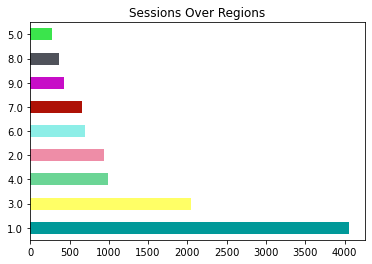

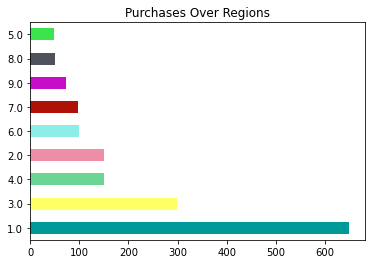

In [20]:
data['Region'].value_counts().plot.barh(color=['#009999','#FFFF66','#6BD595','#EE8DA7','#8DEEE7','#AE1106','#C70DC7','#4F525A','#3BE44C','#F70707'])
plt.title("Sessions Over Regions")
plt.show()
region_purchases = data[data['purchase'] == 1]['Region'].value_counts()
data[data['purchase'] == 1]['Region'].value_counts().plot.barh(color=['#009999','#FFFF66','#6BD595','#EE8DA7','#8DEEE7','#AE1106','#C70DC7','#4F525A','#3BE44C','#F70707'])
plt.title("Purchases Over Regions")
plt.show()

It seems that the proportion of sessions and purchases are very similar over the regions. 

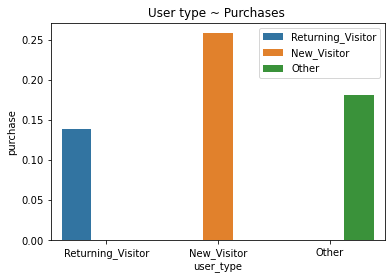

In [21]:
bar1 = sns.barplot(x='user_type', y='purchase', data=data,ci=None,hue= 'user_type')
plt.legend()
plt.title("User type ~ Purchases ")
plt.show()

Here we plotted for every different type of users, how many of them ended up with a purchase.<br> Looks like it has influence on the outcome of the session. 

Weekend Sessions
False    8041
True     2415
Name: Weekend, dtype: int64


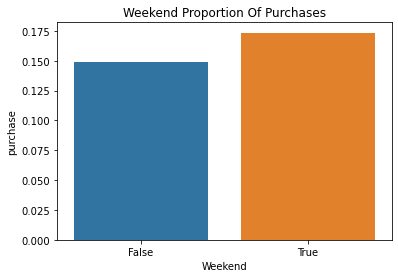

In [22]:
week = data['Weekend'].value_counts()
print("Weekend Sessions")
print(week)
bar1 = sns.barplot(x='Weekend', y='purchase', data=data,ci=None)
plt.title("Weekend Proportion Of Purchases")
plt.show()

Trying to understand if a session that happens during the weekend is more likely to end with a purchase over a week-day session.


In [23]:
A_counts = data['A'].value_counts() 
print("'A' different categorial values:")
print(A_counts)
A_counts = pd.DataFrame(A_counts)

'A' different categorial values:
c_2        3101
c_1        1944
c_3        1644
c_4         850
c_13        586
           ... 
c_20_75       1
c_20_28       1
c_20_33       1
c_20_79       1
c_20_23       1
Name: A, Length: 96, dtype: int64


There are too many categorial variables (96) in the 'A' column. We don't know the meaning of it and if it's not enough it has specific values that have almost no appearence in the data. <br> Therefore we are going to make adjustments here and merge some of them based on the little logic sense we can extract from what we do have. <br> For example c_20_... will be reborn as c_20!

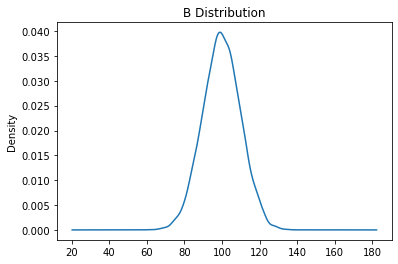

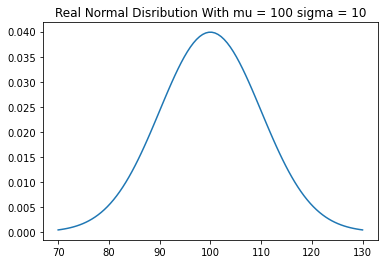

In [24]:
data['B'].plot(kind='kde')
plt.title("B Distribution")
plt.show()
mu = 100
sigma = 10
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title("Real Normal Disribution With mu = 100 sigma = 10")
plt.show()


We first want to examine the distribution of the feature. It seems very suspicious. Looks like feature was generated without any connection to the data.  

count    10456.000000
mean        99.769628
std         10.050268
min         60.733919
25%         93.030568
50%         99.787249
75%        106.506626
max        141.735142
Name: B, dtype: float64


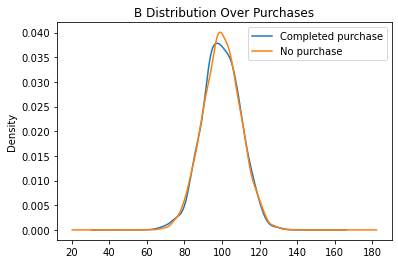

In [25]:
print(data['B'].describe())
data[data['purchase'] == 1]['B'].plot(kind='kde')
data[data['purchase'] == 0]['B'].plot(kind='kde',)
plt.legend(['Completed purchase', 'No purchase'])
plt.title("B Distribution Over Purchases")
plt.show()

We try to see if comes from two different gaussians according to the purchase value. Still doesn't seem helpful to us. <br>
There's almost a perfect match between them.

In [26]:
data['C'].value_counts() 

log200     1813
log400     1760
log404     1754
log8080    1748
log_100    1731
log202     1650
Name: C, dtype: int64

Since we don't know the meaning of C, we want to see how it appears in the data.

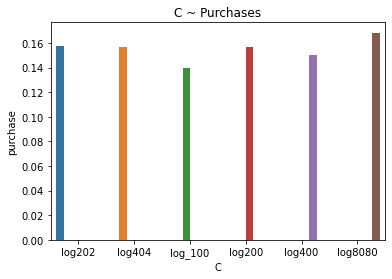

In [27]:
bar_c = sns.barplot(x='C', y='purchase', data=data,ci=None,hue= 'C')
plt.legend('',frameon= False)
plt.title("C ~ Purchases")
plt.show()

Then we want to see if there is a direct connection to the purchase. <br> Doesn't seem to have any.

We suspect the log stands for login \ logout so we search for a clue with Bounce rate and with Exit rate.

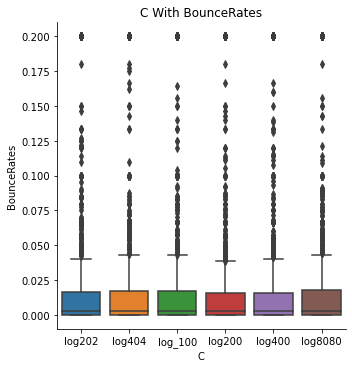

In [28]:
sns.catplot(x='C', y= 'BounceRates',kind='box',data=data)
plt.title("C With BounceRates")
plt.show()

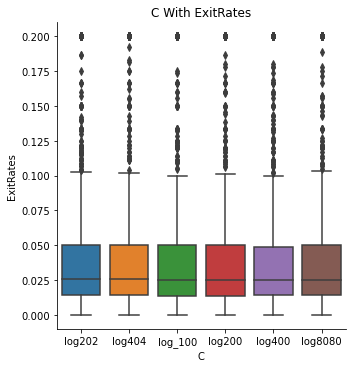

In [29]:
sns.catplot(x='C', y= 'ExitRates',kind='box',data=data)
plt.title("C With ExitRates")
plt.show()


We didn't find any clue, we might think it indicates whether the user logged in via Google account, Facebook, Email etc...

In [30]:
d_na = data['D'].isna().sum()
print("The percent of NaN values in D column is: " +str(d_na/len(data)*100)+"%")


The percent of NaN values in D column is: 98.99799599198397%


In [31]:
d_not_na_purchase = data[data['purchase'] == 1]['D'].notnull().sum()
d_not_na_all = data['D'].notnull().sum()
print("Instances of D with valid value:",d_not_na_all)
print("Instances of D with valid value and a purchase:",d_not_na_purchase)

Instances of D with valid value: 105
Instances of D with valid value and a purchase: 15


There are **a lot** of missing values, though we tried to find some impact we didn't manage to find any significant one, so we'll just drop the column.

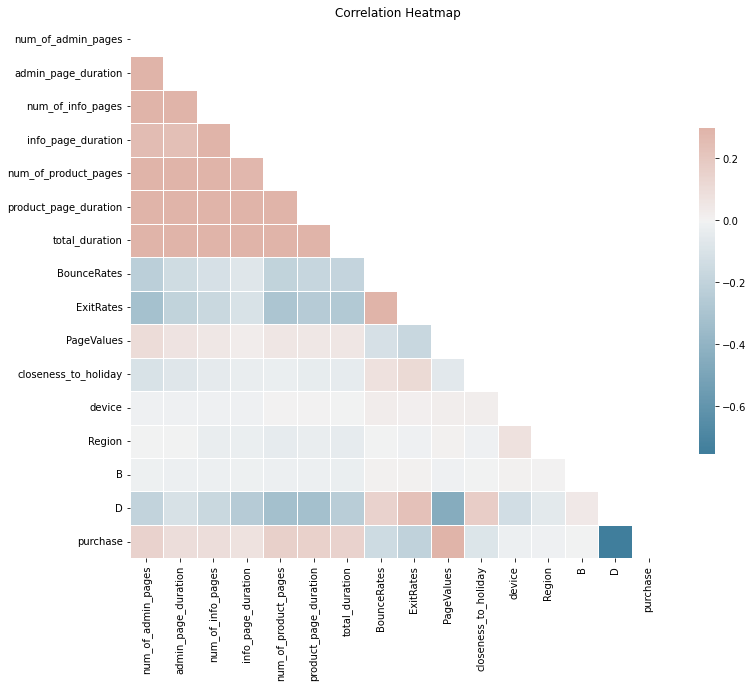

In [32]:
corr = data.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()

Firstly, we do not see a strong enough correlation between 2 features that could allow us to use one of them only.<br>
We do however, see a relatively stong correlation between the number of pages and durations for each individual kind of pages. This can hint us for a possible reduction of features later down the road. <br>
The "duration-pages" area of the heatmap looks significantly more correlated than the rest of the map.<br>
The B column looks like it bearly has any relation with the others, another reason to suspect it has no true meaning for us.

# Preprocessing
### Missing Values Completion

Before applying any changes to the train data, we decided to leave out 10% of it, so we can validate our models in a "test-like" manner. <br>
Any changes that might be applied to our validation/simulated test data would be exactly the same as they should be on the real test data later on.

In [33]:
X_train_in ,X_val_out ,y_train_in, y_val_out = train_test_split(data,data['purchase'],test_size = 0.1, random_state= 42, shuffle=True)


In [34]:
X_train_in.reset_index(inplace=True,drop=True)
X_val_out.reset_index(inplace=True,drop=True)


In [35]:
y_train_in.reset_index(drop=True, inplace=True)
y_val_out.reset_index(drop=True, inplace=True)


In [36]:
data = X_train_in
data


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,5277,0.0,0.00,0.0,0.0,12.0,223.800000,NaN,0.027778,0.017778,...,1.0,safari_14.1,2.0,Returning_Visitor,True,c_4,89.053727,log400,NaN,0
1,1566,0.0,0.00,0.0,0.0,30.0,1791.700000,1791.700000,0.013333,0.031111,...,2.0,edge_96.0.1054.75,1.0,Returning_Visitor,False,c_3,93.559302,log404,NaN,0
2,3666,0.0,0.00,0.0,0.0,35.0,888.333333,888.333333,0.005714,0.024286,...,2.0,chrome_99.1.3,6.0,Returning_Visitor,False,c_3,98.290858,log400,NaN,1
3,5683,2.0,16.20,0.0,0.0,4.0,60.600000,76.800000,0.025000,0.075000,...,2.0,NaN,1.0,Returning_Visitor,False,c_3,105.029990,log8080,NaN,1
4,2039,6.0,389.75,3.0,545.0,65.0,1690.790351,NaN,0.014643,0.034671,...,2.0,browser_10_v16,2.0,Returning_Visitor,True,c_1,91.139385,log200,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,5734,10.0,519.00,0.0,0.0,89.0,2577.960349,NaN,0.012852,0.037291,...,NaN,chrome_98.0.1,7.0,Returning_Visitor,False,c_1,102.585478,log200,NaN,0
9427,5191,2.0,9.00,0.0,0.0,18.0,558.193333,NaN,0.000000,0.011111,...,2.0,chrome_80,3.0,Returning_Visitor,False,c_1,86.700449,log202,NaN,0
9428,5390,7.0,61.08,0.0,0.0,39.0,1324.850000,NaN,0.000000,0.016279,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_4,78.520357,log202,NaN,0
9429,860,0.0,0.00,0.0,0.0,8.0,111.666667,111.666667,0.000000,0.025000,...,2.0,chrome_89,1.0,Returning_Visitor,False,c_1,100.097249,log200,NaN,0


It should not be possible for example, for the number of admin pages to be 0 while the duration that the session took on this kind of page would be non-zero. <br>
With this logic we will make any missing value that has a corresponding 0 with it to 0. <br>
<br>
Moreover, if the total duration of a session is 0, it makes no sense that it will have any positive value in any specific pages feature. So any value in sessions like this, missing or not, should be 0.

In [37]:
null_sum = data.iloc[:,1:8].isna().sum()
print(null_sum)

data["admin_page_duration"] = np.where(data["num_of_admin_pages"] == 0, 0, data.admin_page_duration)
data["num_of_admin_pages"] = np.where(data["admin_page_duration"] == 0, 0, data.num_of_admin_pages)

data["info_page_duration"] = np.where(data["num_of_info_pages"] == 0, 0, data.info_page_duration)
data["num_of_info_pages"] = np.where(data["info_page_duration"] == 0, 0, data.num_of_info_pages)

data["product_page_duration"] = np.where(data["num_of_product_pages"] == 0, 0, data.product_page_duration)
data["num_of_product_pages"] = np.where(data["product_page_duration"] == 0, 0, data.num_of_product_pages)

data.loc[data['total_duration'] == 0 , ['admin_page_duration','num_of_admin_pages','info_page_duration',\
     'num_of_info_pages','product_page_duration','num_of_product_pages']] = 0

null_sum_after = data.iloc[:,1:8].isna().sum()
print(null_sum_after)


num_of_admin_pages        541
admin_page_duration       369
num_of_info_pages         631
info_page_duration        283
num_of_product_pages      357
product_page_duration     559
total_duration           4289
dtype: int64
num_of_admin_pages        278
admin_page_duration       203
num_of_info_pages         146
info_page_duration         84
num_of_product_pages      336
product_page_duration     539
total_duration           4289
dtype: int64


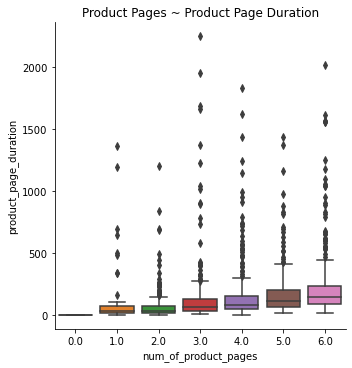

In [38]:
sns.catplot(x ='num_of_product_pages',y='product_page_duration',kind='box',data=data[data["num_of_product_pages"] < 7])
plt.title("Product Pages ~ Product Page Duration")
plt.show()

There seems to be a reasonable growth in the duration when number of pages goes up.<br>
After some more work we will implement this information when filling missing values.

Many missing duration values are singled out, meaning they can be completed using the other three available values. Since this concept has much merit, we went ahead and wrapped it in a function, for it to be simpler to use in the future.

In [39]:
sum_up_durations('admin_page_duration',data)
sum_up_durations('info_page_duration',data)
sum_up_durations('product_page_duration',data)
sum_up_durations('total_duration',data)

In [40]:
null_sum_after = data.iloc[:,1:8].isna().sum()
print(null_sum_after)


num_of_admin_pages       278
admin_page_duration      107
num_of_info_pages        146
info_page_duration        49
num_of_product_pages     336
product_page_duration    267
total_duration           382
dtype: int64


The completion method we used seems to be working well. With more work on the data we should have no more missing values pretty soon.

We use the median duration of every page type for all different number of pages in order to fill missing duration values.

In [41]:
fill_na_duration_by_pages('admin_page_duration','num_of_admin_pages',data,data)
fill_na_duration_by_pages('info_page_duration','num_of_info_pages',data,data)
fill_na_duration_by_pages('product_page_duration','num_of_product_pages',data,data)


For the missing values in the number of pages features we take the duration of every kind of page, and multiply it with and index created by the median of avarage time-per-page calculated over all the data available. To make sure the number is an integer we use the ceiling function.

In [42]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,data)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,data)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)


In [43]:
null_sum_after = data.iloc[:,1:8].isna().sum()
print(null_sum_after)

num_of_admin_pages        11
admin_page_duration       11
num_of_info_pages         20
info_page_duration        20
num_of_product_pages      15
product_page_duration     18
total_duration           382
dtype: int64


Now when we lessened the missing values for the specific pages, we can once again use our functions to sum up durations and fill NA values.

In [44]:
sum_up_durations('admin_page_duration',data)
sum_up_durations('info_page_duration',data)
sum_up_durations('product_page_duration',data)
sum_up_durations('total_duration',data)

In [45]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,data)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,data)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)

In [46]:
null_sum_after = data.iloc[:,1:8].isna().sum()
print(null_sum_after)

num_of_admin_pages       11
admin_page_duration      11
num_of_info_pages        16
info_page_duration       16
num_of_product_pages     14
product_page_duration    17
total_duration           43
dtype: int64


**Let's take another look of our missing data:**

In [47]:
prod_dur = data["product_page_duration"].isna() 
prod_num = data["num_of_product_pages"].isna() 
ad_dur = data["admin_page_duration"].isna()
ad_num = data["num_of_admin_pages"].isna()
inf_dur = data["info_page_duration"].isna()
inf_num = data["num_of_info_pages"].isna()
tot = data["total_duration"].isna()

data[prod_dur|prod_num|ad_dur|ad_num|inf_dur|inf_num|tot]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
181,7780,NaN,NaN,0.0,0.000,9.0,668.000000,NaN,0.000000,0.022222,...,2.0,edge_96.0.1054.72,9.0,Returning_Visitor,False,NaN,89.776796,log404,NaN,0
193,8903,0.0,0.000000,NaN,NaN,6.0,142.900000,NaN,0.000000,0.033333,...,2.0,edge_96.0.1054.75,6.0,Returning_Visitor,False,c_1,111.334236,log_100,NaN,0
470,3021,5.0,66.966667,2.0,416.000,291.0,NaN,NaN,0.001226,0.008660,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_4,95.318888,log400,NaN,0
842,5079,3.0,230.100000,0.0,0.000,NaN,NaN,NaN,0.017647,0.019207,...,3.0,chrome_90.1.7,6.0,Returning_Visitor,False,c_1,98.287124,log_100,NaN,0
914,5338,NaN,NaN,0.0,0.000,41.0,1210.917778,NaN,0.014815,0.014815,...,4.0,chrome_99.1.3,NaN,Returning_Visitor,NaN,c_1,NaN,NaN,NaN,1
982,4281,NaN,NaN,0.0,0.000,70.0,2083.300000,NaN,0.000980,0.005252,...,2.0,chrome_99.1.4,7.0,Returning_Visitor,False,c_2,92.916556,log200,NaN,0
1285,10072,1.0,7.000000,0.0,0.000,NaN,NaN,NaN,0.008889,NaN,...,1.0,NaN,1.0,NaN,True,c_2,NaN,log_100,NaN,0
1377,8265,12.0,176.963855,9.0,266.875,351.0,NaN,NaN,0.012452,0.027372,...,3.0,chrome_89,1.0,Returning_Visitor,False,c_3,92.252487,log400,NaN,0
1528,1922,NaN,NaN,0.0,0.000,125.0,4639.410534,NaN,0.012434,0.023857,...,3.0,chrome_90.1.7,1.0,Returning_Visitor,False,c_4,110.125945,log_100,NaN,0
1824,4606,0.0,0.000000,NaN,NaN,1.0,13.000000,NaN,0.133333,0.133333,...,2.0,browser_5_v10,1.0,Returning_Visitor,False,c_3,91.154000,log202,NaN,0


The missing values are "missing in pairs" which basically means that the duration and number of pages are only missing together - for the same type of pages.<br>
Since most of the info and admin pages and durations are usually low, we complete the rest of the missing values to be 0. <br>
The product pages and duration are not that low, so we complete the rest of the missing values with a general median.

In [48]:
data.loc[(data['admin_page_duration'].isna()),'admin_page_duration'] = 0
data.loc[(data['num_of_admin_pages'].isna()),'num_of_admin_pages'] = 0
data.loc[(data['info_page_duration'].isna()),'info_page_duration'] = 0
data.loc[(data['num_of_info_pages'].isna()),'num_of_info_pages'] = 0
data.loc[data['product_page_duration'].isna(), 'product_page_duration'] = np.nanmedian(data['product_page_duration'])
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)


In [49]:
sum_up_durations('total_duration',data)
null_sum_after = data.iloc[:,1:8].isna().sum()
print(null_sum_after)

num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
dtype: int64


Summing up the values caused very small negative float values to appear where they shouldn't. So in order to avoid any issues we "rounded" them up to 0. 

In [50]:
data.loc[data["info_page_duration"] < 0, "info_page_duration"] = 0
data[data["info_page_duration"] < 0]


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase


Now when every pages feature is inplace, we can move forward!

With strong intuition we've gathered in the exploration of the data, we saw a lot of examples in which bounce and exit rates are exactly 0.2 and the total duration of the session is 0. <br>
Having that in mind, we will use total duration that equals 0, to signify where bounce and exit rates should be 0.2.

In [51]:
data.loc[(data['total_duration'] == 0) & data['BounceRates'].isna(), 'BounceRates'] = 0.2
data.loc[(data['total_duration'] == 0) & data['ExitRates'].isna(), 'ExitRates'] = 0.2

In [52]:
data[data['BounceRates'].isna() | data['ExitRates'].isna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
42,9235,0.0,0.000000,0.0,0.000000,19.0,556.916667,556.916667,NaN,0.022436,...,NaN,chrome_99.1.4,1.0,Returning_Visitor,False,NaN,102.791118,NaN,NaN,0
210,8738,0.0,0.000000,0.0,0.000000,60.0,1806.166667,1806.166667,NaN,0.027941,...,2.0,chrome_99.1.3,2.0,Returning_Visitor,True,c_13,NaN,NaN,NaN,0
505,7293,3.0,64.464286,0.0,0.000000,29.0,1414.589286,1479.053572,NaN,0.012500,...,NaN,NaN,NaN,NaN,NaN,NaN,69.879452,log400,NaN,1
903,6742,1.0,19.200000,0.0,0.000000,3.0,60.600000,79.800000,0.000000,NaN,...,2.0,chrome_89,6.0,NaN,False,NaN,NaN,log8080,NaN,0
1285,10072,1.0,7.000000,0.0,0.000000,21.0,601.880812,608.880812,0.008889,NaN,...,1.0,NaN,1.0,NaN,True,c_2,NaN,log_100,NaN,0
1437,6576,1.0,24.000000,0.0,0.000000,110.0,4670.592114,4694.592114,0.000000,NaN,...,NaN,chrome_89,NaN,Returning_Visitor,NaN,c_1,103.119724,log404,NaN,0
1829,1017,0.0,0.000000,0.0,0.000000,21.0,601.880812,601.880812,0.000000,NaN,...,1.0,NaN,NaN,New_Visitor,NaN,NaN,93.045910,NaN,NaN,0
1995,8770,0.0,0.000000,0.0,0.000000,7.0,194.916667,194.916667,NaN,0.028571,...,NaN,chrome_89,NaN,NaN,NaN,c_2,NaN,log_100,NaN,0
2029,10298,0.0,0.000000,15.0,518.250000,60.0,2068.248473,2586.498473,0.002857,NaN,...,1.0,NaN,1.0,NaN,False,c_2,109.065937,log202,NaN,0
2064,8198,2.0,46.142857,0.0,0.000000,51.0,1742.325216,1788.468073,NaN,NaN,...,2.0,NaN,3.0,Returning_Visitor,True,NaN,NaN,NaN,NaN,0


We've seen that the vast majority of values of BounceRates are 0, and that there are no values of ExitRates that are 0. <br>
So, we figured 0 would be a suitable completion for missing BounceRates, and the median should work well for ExitRates.

In [53]:
data.loc[data['BounceRates'].isna() ,'BounceRates'] = 0
data.loc[data['ExitRates'].isna() ,'ExitRates'] = np.nanmedian(data['ExitRates'])

PageValues is a tricky feature, since it is expected to be of great value for us in the predictions.<br>
In order to not mess with it too much we decided to go with the mean as a filler for missing values.

In [54]:
data.loc[data['PageValues'].isna() ,'PageValues'] = np.mean(data['PageValues'])

The closeness to holiday feature is heavily affected by the month, so we decided to calculate the median value of "closeness" for each month and use it for the missing values of the same month.

In [55]:
mask_isna_holiday = data['closeness_to_holiday'].isna()
month_holiday = np.array(data['Month'])
month_holiday = month_holiday[~pd.isna(month_holiday)]
month_holiday = list(set(month_holiday))
for m in month_holiday:
    data.loc[mask_isna_holiday & (data['Month'] == m), "closeness_to_holiday"] = np.nanmedian(data[(data['Month'] == m)]["closeness_to_holiday"])
data.loc[mask_isna_holiday, "closeness_to_holiday"] = np.nanmedian(data["closeness_to_holiday"])

There are not too many missing month values, so we will arbitrarily assign the 4 most common months to fill missing values.

The first attempt to fill na with a spread of the most common values.

In [56]:
# mask_month_na = data['Month'].isna()
# mult = len(data)/4
# data.loc[mask_month_na & (data['id'] <= mult*1), "Month"] = 'May'
# data.loc[mask_month_na & (mult*1 < data['id']) & (data['id'] <= mult*2), "Month"] = 'Nov'
# data.loc[mask_month_na & (mult*2 < data['id']) & (data['id'] <= mult*3), "Month"] = 'Mar'
# data.loc[mask_month_na & (mult*3 < data['id']), "Month"] = 'Dec'

After some testing, we figured this method might be too scattered.

Using only the most common value achieves better results. <br>
We will stick to one common value.

In [57]:
data['Month'].fillna(data['Month'].value_counts().index[0], inplace=True)


The data contains the full version for each internet browser, so to avoid too many dummy variables later, we narrowed each group to the specific browser type, discarding the versions altogether.

In [58]:
data.loc[(data['internet_browser'].str.startswith('chrome')) & (data['internet_browser'].notnull()), "internet_browser"] = 'chrome'
data.loc[(data['internet_browser'].str.startswith('safari')) & (data['internet_browser'].notnull()), "internet_browser"] = 'safari'
data.loc[(data['internet_browser'].str.startswith('browser')) & (data['internet_browser'].notnull()), "internet_browser"] = 'browser'
data.loc[(data['internet_browser'].str.startswith('edge')) & (data['internet_browser'].notnull()), "internet_browser"] = 'edge'

We assume there's a correlation between the type of device and internet browser in a session. Most likely people use the browser that was already installed on their device. <br>
So, we use the most common browser for a specific device for the missing browser values, and the most common device for a specific browser for the missing device values.

In [59]:
mask_isna_browser = data['internet_browser'].isna()
devices = np.array(data['device'])
devices = devices[~pd.isna(devices)]
devices = list(set(devices))
for d in devices:
    data.loc[mask_isna_browser & (data['device'] == d), "internet_browser"] = data[data['device'] == d]['internet_browser'].value_counts().index[0]

In [60]:
mask_isna_device = data['device'].isna()
browsers = np.array(data['internet_browser'])
browsers = browsers[~pd.isna(browsers)]
browsers = list(set(browsers))
for b in browsers:
    data.loc[mask_isna_device & (data['internet_browser'] == b), "device"] = data[data['internet_browser'] == b]['device'].value_counts().index[0]
data['device'].isna().sum()

24

We will assign the most common value for each feature in the few missing values that still remain.

In [61]:
data.loc[mask_isna_device , "device"] = data['device'].value_counts().index[0]
data.loc[mask_isna_browser , "internet_browser"] = data['internet_browser'].value_counts().index[0]

We assume some kind of correlation between different devices and regions, since the usage of a specific device could be influenced by local trends. <br>
Under this assumption we fill missing region values with the most common region for each device.

In [62]:
mask_isna_region = data['Region'].isna()
for d in devices:
    data.loc[mask_isna_region & (data['device'] == d), "Region"] = data[data['device'] == d]['Region'].value_counts().index[0]

Most users are returning visitors, and there are very few missing values. Filling them with the most common option is our way to go.

In [63]:
print(data['user_type'].value_counts())
data.loc[data['user_type'].isna(), "user_type"] = 'Returning_Visitor'

Returning_Visitor    8057
New_Visitor          1287
Other                  67
Name: user_type, dtype: int64


Most sessions occur during the week, and since the amount of the missing values is not that high, we can rest assure that using the more common value should work out.

In [64]:
print(data['Weekend'].value_counts())
data.loc[data['Weekend'].isna(), "Weekend"] = False

False    7257
True     2156
Name: Weekend, dtype: int64


The many different values in A are suboptimal for us, so we decided we should cluster them. <br>
The first thing is to take all values starting with "c20" and putting them under one name.

In [65]:
data.loc[(data['A'].str.startswith('c_20')) & (data['A'].notnull()), "A"] = 'c_20'
data['A'].value_counts()

c_2     2811
c_1     1713
c_3     1479
c_4      781
c_13     530
c_10     310
c_6      299
c_8      244
c_5      183
c_11     182
c_20     147
c_15      30
c_7       30
c_9       26
c_19      12
c_14       8
c_18       5
c_16       3
c_17       1
Name: A, dtype: int64

Using the most common value to fill in the missing values could be problematic, since there are around 700 of those. <br>
Moreover, we do not know the true meaning of the values. We decided to take the 8 most common values and assign them randomly in batches.

The first attempt to fill na with a spread of the most common values.

In [66]:
# mask_A_na = data['A'].isna()
# num_values = list(data['A'].value_counts())
# names_a = list(data['A'].value_counts().index)
# indexing = num_values[8:0:-1].copy()
# for i in range(1, len(indexing)):
#     indexing[i] = indexing[i] + indexing[i-1]

# data.loc[mask_A_na & (data['id'] <= indexing[0]), "A"] = names_a[8]
# data.loc[mask_A_na & (indexing[7] < data['id']), "A"] = names_a[0]

# for i in range(0,7):      
#     data.loc[mask_A_na & (indexing[i] < data['id']) & (data['id'] <= indexing[i+1]), "A"] = names_a[7-i]


After some testing, we figured this method might be too scattered. Same considerations like before with 'Month'.

Using only the most common value achieves better results. <br>
We will stick to one common value.

In [67]:
data['A'].fillna(data['A'].value_counts().index[0], inplace=True)


The distribution of 'B' was already discussed and examined as normal with mean and variance of 100, so the best option is to randomly assign values from this distribution.

In [68]:
np.random.seed(0)
mask_B_na = data['B'].isna()
rand_B = np.random.normal(loc=100,scale=10,size=len(data[mask_B_na]))
data.loc[mask_B_na , "B"] = rand_B

The distribution of the categories in the C feature seemed to be even, so in order to not create any unwanted bias we randomly select the values we fill in.

In [69]:
mask_C_na = data['C'].isna()
C_logs = data['C'].dropna().unique()
C_rand = []
for i in range(mask_C_na.sum()):
    C_rand.append(C_logs[np.random.randint(6)]) 
data.loc[mask_C_na , "C"] = C_rand

In [70]:
data.isna().sum()

id                          0
num_of_admin_pages          0
admin_page_duration         0
num_of_info_pages           0
info_page_duration          0
num_of_product_pages        0
product_page_duration       0
total_duration              0
BounceRates                 0
ExitRates                   0
PageValues                  0
closeness_to_holiday        0
Month                       0
device                      0
internet_browser            0
Region                      0
user_type                   0
Weekend                     0
A                           0
B                           0
C                           0
D                        9335
purchase                    0
dtype: int64

D has **a lot** of missing values, we thought it would be nearly impossible to learn anything from the values that we do have. <br>
We did eventually find out about _KNNImputer_ which is able to complete missing values with the implementaion of K-Nearest Neighbors.  

In [71]:
imputer = KNNImputer(n_neighbors=15)
imputer.fit(data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]])
numeric_data = pd.DataFrame(imputer.transform(data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]]))
numeric_data.columns = data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]].columns


In [72]:
data.drop(labels=['D'],axis=1,inplace=True)
data['D'] = numeric_data['D']


The imputer calculates the distance using the features that supposed to be categorial but right now they are numeric. <br>
We are aware of that but still comfortable using that method.

In [73]:
data.isna().sum()

id                       0
num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
BounceRates              0
ExitRates                0
PageValues               0
closeness_to_holiday     0
Month                    0
device                   0
internet_browser         0
Region                   0
user_type                0
Weekend                  0
A                        0
B                        0
C                        0
purchase                 0
D                        0
dtype: int64

## Normalizing The Data

In [74]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
# normalize_columns()

## Handling Outliers

After our observation regarding the column B's distribution (which looked almost normal), we figured the best way to eliminate outliers would be to look at the whiskers of a boxplot, and force the outliers into the 0-100% range of the distribution.

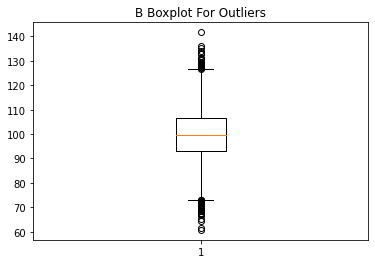

In [75]:
b_prob = plt.boxplot('B',data=data)
b_lst = [item.get_ydata()[1] for item in b_prob['whiskers']]
data.loc[data['B'] > b_lst[1], "B"] = b_lst[1]
data.loc[data['B'] < b_lst[0], "B"] = b_lst[0]
plt.title("B Boxplot For Outliers")
plt.show()

We wanted to use the same formula for the outliers handling in all of our numeric features. For each feature we select the threshold, and all values higher than it will match to it.

In [76]:
outliers_handling('admin_page_duration', 99.5 ,data,data)
outliers_handling('info_page_duration', 99.5 ,data,data)
outliers_handling('product_page_duration', 99.5 ,data,data)
outliers_handling('total_duration', 99.2 ,data,data)
outliers_handling('num_of_admin_pages', 99.2 ,data,data)
outliers_handling('num_of_info_pages', 99.2 ,data,data)
outliers_handling('num_of_product_pages', 99.5 ,data,data)


The number of values that has changed:  48
The number of values that has changed:  48
The number of values that has changed:  48
The number of values that has changed:  76
The number of values that has changed:  62
The number of values that has changed:  59
The number of values that has changed:  48


## Manipulations On Existing Features
Looking at the data in the exploration part, we've noticed that admin and info pages are not correlated with purchases as strongly as product pages and other featuers. <br>
We decided we should try manipulating those features.

In [77]:
data2 = data.copy()
data2.insert(1,'non_product_duration' , (data2['admin_page_duration'] + data2['info_page_duration']) )
data2.insert(1,'num_of_non_product_pages' , (data2['num_of_admin_pages'] + data2['num_of_info_pages']) )
data2.drop(columns=['num_of_admin_pages','admin_page_duration','num_of_info_pages','info_page_duration'],inplace=True)


We've tried manipulating the data as presented above in order to reduce dimensionality. We merged the duration and number of pages that are not product pages, believing they are of less importance. After trying this manipulation in models we found out it only damages the prediction, so we decided to discard it.

Now we need to handle categorial variables. We take the straight forward way and create dummy variables. 

In [78]:
print("Data dimension before implementing dummy variables: "+str(data.shape))
data_dummies = pd.get_dummies(data,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])
print("Data dimension after implementing dummy variables: "+str(data_dummies.shape))


Data dimension before implementing dummy variables: (9431, 23)
Data dimension after implementing dummy variables: (9431, 81)


Now we're afraid the dimensionality will curse us!

## Dimensionality Reduction

Since the A column has many different categories in it, we prefer limiting the amount of dummy variable it will produce. We decided to unite all different values that had less than 40 instances of under the umbrella of "c_other".

In [79]:
val_cnt = data['A'].value_counts()
c_others = list(val_cnt[val_cnt<len(data)*0.01].index)

for c in c_others:
    data.loc[data['A'] == c, 'A'] = 'c_other'


After trying PCA, we figured knowing the true meaning of our features is preferable. <br>
We decided we should implement forward selection for every model individually. <br>
Since forward selecting features for every one of the models took a significant time to run, we decided to select 20 features (an avarge best preformer) with random forest as the classifier. <br>
This implementaion will be presented right before the start of the models themselves.

## Preprocessing On Test Data 

We will process the real test data while also implementing the same changes on our simulated test that was separeted from our data. <br>
This will help us evaluate our models on a 'test-like' dataset. 

In [80]:
test = pd.read_csv("test.csv")
test.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
0,0,0.0,0.0,0.0,0.0 minutes,2.0,64.0 minutes,NaN,0.00,0.10,...,Feb,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_2,92.487250,log200,NaN
1,1,0.0,0.0,0.0,0.0 minutes,2.0,2.666666667 minutes,NaN,0.05,0.14,...,Feb,3.0,chrome_98.0.1,2.0,Returning_Visitor,False,c_4,120.493478,log400,NaN
2,2,1.0,0.0,0.0,0.0 minutes,0.0,NaN,0.0,0.20,0.20,...,Feb,1.0,chrome_99.1.3,1.0,Returning_Visitor,True,c_5,94.120580,log400,NaN
3,3,0.0,NaN,0.0,0.0 minutes,2.0,32.0 minutes,32.0,0.00,0.10,...,Feb,2.0,chrome_90.1.7,1.0,Returning_Visitor,False,c_3,115.990484,log8080,NaN
4,4,0.0,0.0,0.0,0.0 minutes,4.0,63.0 minutes,NaN,0.00,0.05,...,Feb,2.0,browser_6_v12,1.0,Returning_Visitor,False,c_3,93.866618,log404,NaN


In [81]:
test["info_page_duration"] = test["info_page_duration"].replace("minutes", "", regex=True).astype("float64")
test["product_page_duration"] = test["product_page_duration"].replace("minutes", "", regex=True).astype("float64")

In [82]:
null_sum = test.iloc[:,1:8].isna().sum()
print(null_sum)

test["admin_page_duration"] = np.where(test["num_of_admin_pages"] == 0, 0, test.admin_page_duration)
test["num_of_admin_pages"] = np.where(test["admin_page_duration"] == 0, 0, test.num_of_admin_pages)

test["info_page_duration"] = np.where(test["num_of_info_pages"] == 0, 0, test.info_page_duration)
test["num_of_info_pages"] = np.where(test["info_page_duration"] == 0, 0, test.num_of_info_pages)

test["product_page_duration"] = np.where(test["num_of_product_pages"] == 0, 0, test.product_page_duration)
test["num_of_product_pages"] = np.where(test["product_page_duration"] == 0, 0, test.num_of_product_pages)

test.loc[test['total_duration'] == 0 , ['admin_page_duration','num_of_admin_pages','info_page_duration',\
     'num_of_info_pages','product_page_duration','num_of_product_pages']] = 0

null_sum_after = test.iloc[:,1:8].isna().sum()
print(null_sum_after)


num_of_admin_pages        93
admin_page_duration       78
num_of_info_pages        126
info_page_duration        64
num_of_product_pages      77
product_page_duration    113
total_duration           844
dtype: int64
num_of_admin_pages        54
admin_page_duration       41
num_of_info_pages         33
info_page_duration        17
num_of_product_pages      72
product_page_duration    106
total_duration           844
dtype: int64


In [83]:
sum_up_durations('admin_page_duration',test)
sum_up_durations('info_page_duration',test)
sum_up_durations('product_page_duration',test)
sum_up_durations('total_duration',test)

In [84]:
fill_na_duration_by_pages('admin_page_duration','num_of_admin_pages',data,test)
fill_na_duration_by_pages('info_page_duration','num_of_info_pages',data,test)
fill_na_duration_by_pages('product_page_duration','num_of_product_pages',data,test)

In [85]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)

In [86]:
sum_up_durations('admin_page_duration',test)
sum_up_durations('info_page_duration',test)
sum_up_durations('product_page_duration',test)
sum_up_durations('total_duration',test)

In [87]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)

In [88]:
test.loc[(test['admin_page_duration'].isna()),'admin_page_duration'] = 0
test.loc[(test['num_of_admin_pages'].isna()),'num_of_admin_pages'] = 0
test.loc[(test['info_page_duration'].isna()),'info_page_duration'] = 0
test.loc[(test['num_of_info_pages'].isna()),'num_of_info_pages'] = 0
test.loc[test['product_page_duration'].isna(), 'product_page_duration'] = np.nanmedian(data['product_page_duration'])
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)


In [89]:
sum_up_durations('total_duration',test)
null_sum_after = test.iloc[:,1:8].isna().sum()
print(null_sum_after)

num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
dtype: int64


In [90]:
test.loc[test["info_page_duration"] < 0, "info_page_duration"] = 0


In [91]:
test.loc[(test['total_duration'] == 0) & test['BounceRates'].isna(), 'BounceRates'] = 0.2
test.loc[(test['total_duration'] == 0) & test['ExitRates'].isna(), 'ExitRates'] = 0.2

In [92]:
test[test['BounceRates'].isna() | test['ExitRates'].isna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
238,238,3.0,69.166667,0.0,0.000000,25.0,684.389583,753.556250,NaN,NaN,...,Mar,4.0,safari_13.1,NaN,Returning_Visitor,NaN,c_2,93.688782,NaN,NaN
338,338,0.0,0.000000,0.0,0.000000,21.0,601.880812,601.880812,NaN,NaN,...,May,1.0,safari_14,6.0,NaN,False,NaN,94.722954,log8080,NaN
1039,1039,4.0,54.600000,2.0,22.133333,37.0,1100.789082,1177.522415,NaN,0.018561,...,NaN,2.0,NaN,NaN,NaN,False,c_1,NaN,log404,NaN


In [93]:
test.loc[test['BounceRates'].isna() ,'BounceRates'] = 0
test.loc[test['ExitRates'].isna() ,'ExitRates'] = np.nanmedian(data['ExitRates'])


In [94]:
test.loc[test['PageValues'].isna() ,'PageValues'] = np.mean(data['PageValues'])


In [95]:
test['Month'].unique()

array(['Feb', 'Mar', nan, 'May', 'June', 'Sep', 'Nov', 'Aug', 'Jul',
       'Oct', 'Dec'], dtype=object)

In [96]:
data['Month']

0       Jul
1       Mar
2       May
3       Sep
4       May
       ... 
9426    Jul
9427    Aug
9428    Oct
9429    Mar
9430    Nov
Name: Month, Length: 9431, dtype: object

In [97]:
mask_isna_holiday = test['closeness_to_holiday'].isna()
month_holiday = np.array(test['Month'])
month_holiday = month_holiday[~pd.isna(month_holiday)]
month_holiday = list(set(month_holiday))
for m in month_holiday:
    test.loc[mask_isna_holiday & (test['Month'] == m), "closeness_to_holiday"] = np.nanmedian(data[(data['Month'] == m)]["closeness_to_holiday"])

test.loc[mask_isna_holiday, "closeness_to_holiday"] = np.nanmedian(data["closeness_to_holiday"])


In [98]:
# mask_month_na = test['Month'].isna()
# mult = len(test)/4
# test.loc[mask_month_na & (test['id'] <= mult*1), "Month"] = 'May'
# test.loc[mask_month_na & (mult*1 < test['id']) & (test['id'] <= mult*2), "Month"] = 'Nov'
# test.loc[mask_month_na & (mult*2 < test['id']) & (test['id'] <= mult*3), "Month"] = 'Mar'
# test.loc[mask_month_na & (mult*3 < test['id']), "Month"] = 'Dec'


In [99]:
test['Month'].fillna(data['Month'].value_counts().index[0], inplace=True)


In [100]:
test.loc[(test['internet_browser'].str.startswith('chrome')) & (test['internet_browser'].notnull()), "internet_browser"] = 'chrome'
test.loc[(test['internet_browser'].str.startswith('safari')) & (test['internet_browser'].notnull()), "internet_browser"] = 'safari'
test.loc[(test['internet_browser'].str.startswith('browser')) & (test['internet_browser'].notnull()), "internet_browser"] = 'browser'
test.loc[(test['internet_browser'].str.startswith('edge')) & (test['internet_browser'].notnull()), "internet_browser"] = 'edge'

In [101]:
mask_isna_browser = test['internet_browser'].isna()
devices = np.array(test['device'])
devices = devices[~pd.isna(devices)]
devices = list(set(devices))
for d in devices:
    test.loc[mask_isna_browser & (test['device'] == d), "internet_browser"] = data[data['device'] == d]['internet_browser'].value_counts().index[0]
    

In [102]:
mask_isna_device = test['device'].isna()
browsers = np.array(test['internet_browser'])
browsers = browsers[~pd.isna(browsers)]
browsers = list(set(browsers))
for b in browsers:
    test.loc[mask_isna_device & (test['internet_browser'] == b), "device"] = data[data['internet_browser'] == b]['device'].value_counts().index[0]


In [103]:
test.loc[mask_isna_device , "device"] = data['device'].value_counts().index[0]
test.loc[mask_isna_browser , "internet_browser"] = data['internet_browser'].value_counts().index[0]


In [104]:
mask_isna_region = test['Region'].isna()
for d in devices:
    test.loc[mask_isna_region & (test['device'] == d), "Region"] = data[data['device'] == d]['Region'].value_counts().index[0]


In [105]:
print(test['user_type'].value_counts())
test.loc[test['user_type'].isna(), "user_type"] = 'Returning_Visitor'


Returning_Visitor    1577
New_Visitor           259
Other                  13
Name: user_type, dtype: int64


In [106]:
print(test['Weekend'].value_counts())
test.loc[test['Weekend'].isna(), "Weekend"] = False


False    1408
True      441
Name: Weekend, dtype: int64


In [107]:
test.loc[(test['A'].str.startswith('c_20')) & (test['A'].notnull()), "A"] = 'c_20'


Implementing the same concept as before. 

In [108]:
# mask_A_na = test['A'].isna()
# num_values = list(data['A'].value_counts())
# names_a = list(data['A'].value_counts().index)
# indexing = num_values[8:0:-1].copy()
# for i in range(1, len(indexing)):
#     indexing[i] = indexing[i] + indexing[i-1]

# test.loc[mask_A_na & (test['id'] <= indexing[0]), "A"] = names_a[8]
# test.loc[mask_A_na & (indexing[7] < test['id']), "A"] = names_a[0]

# for i in range(0,7):      
#     test.loc[mask_A_na & (indexing[i] < test['id']) & (test['id'] <= indexing[i+1]), "A"] = names_a[7-i]


In [109]:
test['A'].fillna(data['A'].value_counts().index[0], inplace=True)


In [110]:
np.random.seed(0)
mask_B_na = test['B'].isna()
rand_B = np.random.normal(loc=100,scale=10,size=len(test[mask_B_na]))
test.loc[mask_B_na , "B"] = rand_B


In [111]:
mask_C_na = test['C'].isna()
C_logs = data['C'].dropna().unique()
C_rand = []
for i in range(mask_C_na.sum()):
    C_rand.append(C_logs[np.random.randint(6)]) 
test.loc[mask_C_na , "C"] = C_rand


In [112]:
test.isna().sum()

id                          0
num_of_admin_pages          0
admin_page_duration         0
num_of_info_pages           0
info_page_duration          0
num_of_product_pages        0
product_page_duration       0
total_duration              0
BounceRates                 0
ExitRates                   0
PageValues                  0
closeness_to_holiday        0
Month                       0
device                      0
internet_browser            0
Region                      0
user_type                   0
Weekend                     0
A                           0
B                           0
C                           0
D                        1832
dtype: int64

After learning from the train, we implement our knowledge on the test to fill na values.

In [113]:
numeric_test = pd.DataFrame(imputer.transform(test[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]]))
numeric_test.columns = data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]].columns


In [114]:
test.drop(labels=['D'],axis=1,inplace=True)
test['D'] = numeric_test['D']


In [115]:
test.isna().sum()

id                       0
num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
BounceRates              0
ExitRates                0
PageValues               0
closeness_to_holiday     0
Month                    0
device                   0
internet_browser         0
Region                   0
user_type                0
Weekend                  0
A                        0
B                        0
C                        0
D                        0
dtype: int64

In [116]:
for c in c_others:
    test.loc[test['A'] == c, 'A'] = 'c_other'
test['A'].value_counts()


c_2        683
c_1        331
c_3        289
c_4        143
c_13       109
c_6         76
c_10        57
c_8         49
c_5         36
c_11        27
c_20        26
c_other     24
c_12         1
Name: A, dtype: int64

In [117]:
test = pd.get_dummies(test,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])
columns = list(data_dummies.iloc[:,1:].columns)

for col in columns:
    if col not in test.columns:
        test[str(col)] = np.zeros(len(test))
        print(col)


purchase
A_c_14
A_c_15
A_c_16
A_c_17
A_c_18
A_c_19
A_c_7
A_c_9


Preprocess on simulated test

In [118]:
test_sim = X_val_out
test_sim_pred = y_val_out

In [119]:
test_sim["info_page_duration"] = test_sim["info_page_duration"].replace("minutes", "", regex=True).astype("float64")
test_sim["product_page_duration"] = test_sim["product_page_duration"].replace("minutes", "", regex=True).astype("float64")

In [120]:
null_sum = test_sim.iloc[:,1:8].isna().sum()
print(null_sum)

test_sim["admin_page_duration"] = np.where(test_sim["num_of_admin_pages"] == 0, 0, test_sim.admin_page_duration)
test_sim["num_of_admin_pages"] = np.where(test_sim["admin_page_duration"] == 0, 0, test_sim.num_of_admin_pages)

test_sim["info_page_duration"] = np.where(test_sim["num_of_info_pages"] == 0, 0, test_sim.info_page_duration)
test_sim["num_of_info_pages"] = np.where(test_sim["info_page_duration"] == 0, 0, test_sim.num_of_info_pages)

test_sim["product_page_duration"] = np.where(test_sim["num_of_product_pages"] == 0, 0, test_sim.product_page_duration)
test_sim["num_of_product_pages"] = np.where(test_sim["product_page_duration"] == 0, 0, test_sim.num_of_product_pages)

test_sim.loc[test_sim['total_duration'] == 0 , ['admin_page_duration','num_of_admin_pages','info_page_duration',\
     'num_of_info_pages','product_page_duration','num_of_product_pages']] = 0

null_sum_after = test_sim.iloc[:,1:8].isna().sum()
print(null_sum_after)


num_of_admin_pages        64
admin_page_duration       44
num_of_info_pages         56
info_page_duration        34
num_of_product_pages      46
product_page_duration     62
total_duration           464
dtype: int64
num_of_admin_pages        45
admin_page_duration       23
num_of_info_pages         10
info_page_duration         9
num_of_product_pages      46
product_page_duration     60
total_duration           464
dtype: int64


In [121]:
sum_up_durations('admin_page_duration',test_sim)
sum_up_durations('info_page_duration',test_sim)
sum_up_durations('product_page_duration',test_sim)
sum_up_durations('total_duration',test_sim)

In [122]:
fill_na_duration_by_pages('admin_page_duration','num_of_admin_pages',data,test_sim)
fill_na_duration_by_pages('info_page_duration','num_of_info_pages',data,test_sim)
fill_na_duration_by_pages('product_page_duration','num_of_product_pages',data,test_sim)

In [123]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test_sim)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test_sim)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test_sim)

In [124]:
sum_up_durations('admin_page_duration',test_sim)
sum_up_durations('info_page_duration',test_sim)
sum_up_durations('product_page_duration',test_sim)
sum_up_durations('total_duration',test_sim)

In [125]:
fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test_sim)
fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test_sim)
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test_sim)

In [126]:
test_sim.loc[(test_sim['admin_page_duration'].isna()),'admin_page_duration'] = 0
test_sim.loc[(test_sim['num_of_admin_pages'].isna()),'num_of_admin_pages'] = 0
test_sim.loc[(test_sim['info_page_duration'].isna()),'info_page_duration'] = 0
test_sim.loc[(test_sim['num_of_info_pages'].isna()),'num_of_info_pages'] = 0
test_sim.loc[test_sim['product_page_duration'].isna(), 'product_page_duration'] = np.nanmedian(data['product_page_duration'])
fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test_sim)


In [127]:
sum_up_durations('total_duration',test_sim)
null_sum_after = test_sim.iloc[:,1:8].isna().sum()
print(null_sum_after)

num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
dtype: int64


In [128]:
test_sim.loc[test_sim["info_page_duration"] < 0, "info_page_duration"] = 0


In [129]:
test_sim.loc[(test_sim['total_duration'] == 0) & test_sim['BounceRates'].isna(), 'BounceRates'] = 0.2
test_sim.loc[(test_sim['total_duration'] == 0) & test_sim['ExitRates'].isna(), 'ExitRates'] = 0.2

In [130]:
test_sim[test_sim['BounceRates'].isna() | test_sim['ExitRates'].isna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
147,8182,0.0,0.000000,0.0,0.0,5.0,178.833333,178.833333,NaN,0.04,...,2.0,chrome_99.1.3,7.0,Returning_Visitor,NaN,c_13,96.252832,log200,NaN,0
389,4710,8.0,164.066667,0.0,0.0,37.0,1553.523810,1717.590477,NaN,NaN,...,NaN,chrome_80,1.0,NaN,False,NaN,100.699650,NaN,NaN,0
406,6691,0.0,0.000000,0.0,0.0,3.0,72.000000,72.000000,0.0,NaN,...,NaN,NaN,6.0,NaN,NaN,c_5,98.350021,NaN,NaN,0
893,6630,0.0,0.000000,0.0,0.0,3.0,61.500000,61.500000,0.0,NaN,...,3.0,browser_6_v12,3.0,Returning_Visitor,NaN,NaN,NaN,log_100,NaN,1


In [131]:
test_sim.loc[test_sim['BounceRates'].isna() ,'BounceRates'] = 0
test_sim.loc[test_sim['ExitRates'].isna() ,'ExitRates'] = np.nanmedian(data['ExitRates'])


In [132]:
test_sim.loc[test_sim['PageValues'].isna() ,'PageValues'] = np.mean(data['PageValues'])


In [133]:
mask_isna_holiday = test_sim['closeness_to_holiday'].isna()
month_holiday = np.array(test_sim['Month'])
month_holiday = month_holiday[~pd.isna(month_holiday)]
month_holiday = list(set(month_holiday))
for m in month_holiday:
    test_sim.loc[mask_isna_holiday & (test_sim['Month'] == m), "closeness_to_holiday"] = np.nanmedian(data[(data['Month'] == m)]["closeness_to_holiday"])

test_sim.loc[mask_isna_holiday, "closeness_to_holiday"] = np.nanmedian(data["closeness_to_holiday"])



In [134]:
# mask_month_na = test_sim['Month'].isna()
# mult = len(test_sim)/4
# test_sim.loc[mask_month_na & (test_sim['id'] <= mult*1), "Month"] = 'May'
# test_sim.loc[mask_month_na & (mult*1 < test_sim['id']) & (test_sim['id'] <= mult*2), "Month"] = 'Nov'
# test_sim.loc[mask_month_na & (mult*2 < test_sim['id']) & (test_sim['id'] <= mult*3), "Month"] = 'Mar'
# test_sim.loc[mask_month_na & (mult*3 < test_sim['id']), "Month"] = 'Dec'


In [135]:
test_sim['Month'].fillna(data['Month'].value_counts().index[0], inplace=True)


In [136]:
test_sim.loc[(test_sim['internet_browser'].str.startswith('chrome')) & (test_sim['internet_browser'].notnull()), "internet_browser"] = 'chrome'
test_sim.loc[(test_sim['internet_browser'].str.startswith('safari')) & (test_sim['internet_browser'].notnull()), "internet_browser"] = 'safari'
test_sim.loc[(test_sim['internet_browser'].str.startswith('browser')) & (test_sim['internet_browser'].notnull()), "internet_browser"] = 'browser'
test_sim.loc[(test_sim['internet_browser'].str.startswith('edge')) & (test_sim['internet_browser'].notnull()), "internet_browser"] = 'edge'

In [137]:
mask_isna_browser = test_sim['internet_browser'].isna()
devices = np.array(test_sim['device'])
devices = devices[~pd.isna(devices)]
devices = list(set(devices))
for d in devices:
    test_sim.loc[mask_isna_browser & (test_sim['device'] == d), "internet_browser"] = data[data['device'] == d]['internet_browser'].value_counts().index[0]
    

In [138]:
mask_isna_device = test_sim['device'].isna()
browsers = np.array(test_sim['internet_browser'])
browsers = browsers[~pd.isna(browsers)]
browsers = list(set(browsers))
for b in browsers:
    test_sim.loc[mask_isna_device & (test_sim['internet_browser'] == b), "device"] = data[data['internet_browser'] == b]['device'].value_counts().index[0]


In [139]:
test_sim.loc[mask_isna_device , "device"] = data['device'].value_counts().index[0]
test_sim.loc[mask_isna_browser , "internet_browser"] = data['internet_browser'].value_counts().index[0]


In [140]:
mask_isna_region = test_sim['Region'].isna()
for d in devices:
    test_sim.loc[mask_isna_region & (test_sim['device'] == d), "Region"] = data[data['device'] == d]['Region'].value_counts().index[0]


In [141]:
print(test_sim['user_type'].value_counts())
test_sim.loc[test_sim['user_type'].isna(), "user_type"] = 'Returning_Visitor'


Returning_Visitor    899
New_Visitor          141
Other                  5
Name: user_type, dtype: int64


In [142]:
print(test_sim['Weekend'].value_counts())
test_sim.loc[test_sim['Weekend'].isna(), "Weekend"] = False


False    784
True     259
Name: Weekend, dtype: int64


In [143]:
test_sim.loc[(test_sim['A'].str.startswith('c_20')) & (test_sim['A'].notnull()), "A"] = 'c_20'


In [144]:
# mask_A_na = test_sim['A'].isna()
# num_values = list(data['A'].value_counts())
# names_a = list(data['A'].value_counts().index)
# indexing = num_values[8:0:-1].copy()
# for i in range(1, len(indexing)):
#     indexing[i] = indexing[i] + indexing[i-1]

# test_sim.loc[mask_A_na & (test_sim['id'] <= indexing[0]), "A"] = names_a[8]
# test_sim.loc[mask_A_na & (indexing[7] < test_sim['id']), "A"] = names_a[0]

# for i in range(0,7):      
#     test_sim.loc[mask_A_na & (indexing[i] < test_sim['id']) & (test_sim['id'] <= indexing[i+1]), "A"] = names_a[7-i]


In [145]:
test_sim['A'].fillna(data['A'].value_counts().index[0], inplace=True)


In [146]:
np.random.seed(0)
mask_B_na = test_sim['B'].isna()
rand_B = np.random.normal(loc=100,scale=10,size=len(test_sim[mask_B_na]))
test_sim.loc[mask_B_na , "B"] = rand_B


In [147]:
mask_C_na = test_sim['C'].isna()
C_logs = data['C'].dropna().unique()
C_rand = []
for i in range(mask_C_na.sum()):
    C_rand.append(C_logs[np.random.randint(6)]) 
test_sim.loc[mask_C_na , "C"] = C_rand


In [148]:
test_sim.isna().sum()

id                          0
num_of_admin_pages          0
admin_page_duration         0
num_of_info_pages           0
info_page_duration          0
num_of_product_pages        0
product_page_duration       0
total_duration              0
BounceRates                 0
ExitRates                   0
PageValues                  0
closeness_to_holiday        0
Month                       0
device                      0
internet_browser            0
Region                      0
user_type                   0
Weekend                     0
A                           0
B                           0
C                           0
D                        1039
purchase                    0
dtype: int64

In [149]:
numeric_test_sim = pd.DataFrame(imputer.transform(test_sim[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]]))
numeric_test_sim.columns = data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
            "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]].columns


In [150]:
test_sim.drop(labels=['D'],axis=1,inplace=True)
test_sim['D'] = numeric_test_sim['D']


In [151]:
test_sim.isna().sum()

id                       0
num_of_admin_pages       0
admin_page_duration      0
num_of_info_pages        0
info_page_duration       0
num_of_product_pages     0
product_page_duration    0
total_duration           0
BounceRates              0
ExitRates                0
PageValues               0
closeness_to_holiday     0
Month                    0
device                   0
internet_browser         0
Region                   0
user_type                0
Weekend                  0
A                        0
B                        0
C                        0
purchase                 0
D                        0
dtype: int64

In [152]:
for c in c_others:
    test_sim.loc[test_sim['A'] == c, 'A'] = 'c_other'
test_sim['A'].value_counts()


c_2        359
c_1        231
c_3        165
c_4         69
c_13        56
c_10        37
c_6         36
c_8         24
c_5         22
c_11        17
c_other     17
c_20        15
Name: A, dtype: int64

In [153]:
test_sim_dummies = pd.get_dummies(test_sim,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])
columns = list(data_dummies.iloc[:,1:].columns)

for col in columns:
    if col not in test_sim_dummies.columns:
        test_sim_dummies[str(col)] = np.zeros(len(test_sim_dummies))
        print(col)


device_5.0
device_6.0
A_c_14
A_c_15
A_c_16
A_c_17
A_c_18
A_c_19
A_c_7
A_c_9


Taking another look on our correlations after finished to process the data

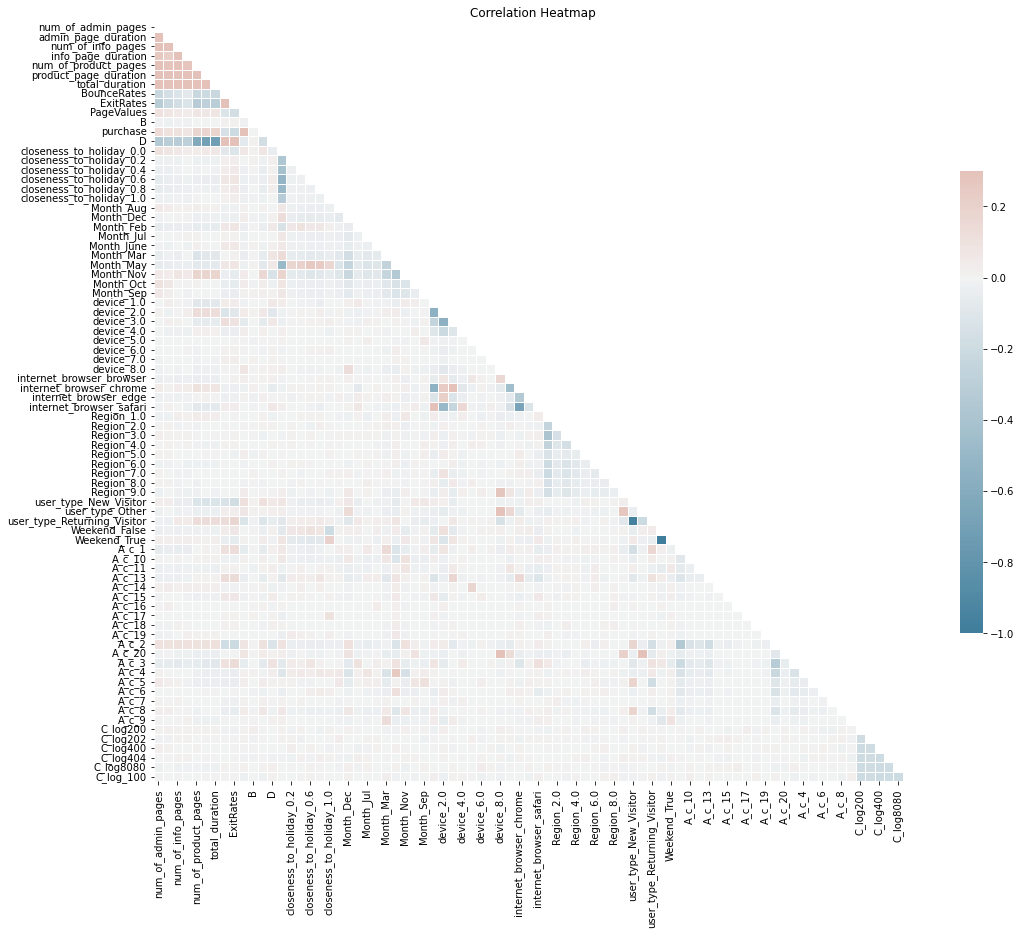

In [154]:
corr = data_dummies.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()


# Models

## Data Organization

First, we want to organize our data into different sets in order to test different approaches. <br> 
There is the clean data, the data after Min-Max normalization and the relative normalization that we created before.

In [155]:
data_dummies = pd.get_dummies(data,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])
X = data_dummies.copy()
y = data['purchase']
X = X.drop(labels= ['id','purchase'],axis=1)

Z = test_sim_dummies.copy()
t = y_val_out
Z = Z.drop(labels= ['id','purchase'],axis=1)


X_numeric = [0,1,2,3,4,5,6,9]

X_min_max = X.copy()
X_numeric_col = min_max_scaler.fit_transform(X.iloc[:,X_numeric])
X_min_max.iloc[:,X_numeric] = X_numeric_col

X_norm = X.copy()
normalize_columns(X.columns[X_numeric],X_norm)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_faster = ShuffleSplit(n_splits=2, test_size=0.15, random_state=42)


To run the models a little bit faster we use the _n-jobs_ parameter of sklearn. <br>
In order to squeeze the most for the system we fetch the number of available CPU cores, we shall use (almost all of) them later on...

In [156]:
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


We would have prefered adjusting our features lists according to every single model.<br> 
Due to time restrictions we are not capable of doing that, so we will run our models with the feature that Random Forest found best suitable, since it should be our selected model.

In [157]:
parameters = {'n_estimators':[200,250], 'max_depth':[10,15],'min_samples_leaf':[4,8],'criterion':['gini','entropy'] }
rf = RandomForestClassifier(random_state=42)
gscv = GridSearchCV(rf, parameters, scoring='roc_auc',cv=cv, n_jobs=(n_cpu-1))
gscv.fit(X, y)


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [4, 8],
                         'n_estimators': [200, 250]},
             scoring='roc_auc')

In [158]:
best_params_first = gscv.best_params_
best_score = gscv.best_score_
print(f'Best Params: {best_params_first} \n')
print(f'Train AUC score for best params: {gscv.best_score_}')


Best Params: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 4, 'n_estimators': 250} 

Train AUC score for best params: 0.9366130249454756


The SequentialFeatureSelector(SFS) function takes a model and runs the feature selection based on parameters such as direction (backward\forward), scoring, number of features etc... <br>
We are using the forward selection so it will choose the feature that improves the score the most. 

In [159]:
rf = RandomForestClassifier(random_state=42, **best_params_first)
sfs = SFS(rf ,direction= 'forward',scoring='roc_auc',cv=2 ,n_features_to_select=20, n_jobs=(n_cpu-1))
sfs.fit(X, y)


SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(criterion='entropy',
                                                           max_depth=15,
                                                           min_samples_leaf=4,
                                                           n_estimators=250,
                                                           random_state=42),
                          n_features_to_select=20, n_jobs=7, scoring='roc_auc')

In [160]:
feat = sfs.get_feature_names_out()
feat

array(['num_of_admin_pages', 'num_of_product_pages', 'ExitRates',
       'PageValues', 'closeness_to_holiday_0.6', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_Mar', 'Month_May', 'Month_Nov', 'Region_2.0',
       'Region_6.0', 'Region_9.0', 'Weekend_False', 'A_c_1', 'A_c_13',
       'A_c_3', 'A_c_other', 'C_log202'], dtype=object)

At first, we tried using a methodical system through the entirety of the project to optimize our model: <br>
First we wanted to get a head start with good Hyper-parameters that will help us to determine our selected features due to a serious dimensionality issues. <br>
We tried to use PCA but the models and us both found Forward-Selection better.<br> We recieved better results and enjoyed better understanding of our models, and could more easily make assumptions and deductions about our outcomes.<br>
After choosing the features we reran GSCV in order to readujst the hyper parameters, a concept that was abandoned with the whole selection flow. <br>
Normalizations were tested along the way but proved inefficient, so we did not follow through with them.

This method was our prreferd workflow, but due to runtime considerations we had to abandon it.<br>
Going forward we used the 20 features our forward selector found best.

## Basic Models

### KNN <br>
A model that project results based on the nearest "neighbors" (distances) .

Running the Hyper-parameter selection after choosing the best 20 features with Forward-Selection (With random forest).

In [161]:
parameters = {'n_neighbors':[*range(21, 102, 2)], 'weights':['uniform', 'distance'],
                'algorithm':['brute'], 'metric': ['euclidean'] }
knn = KNeighborsClassifier(n_jobs=(n_cpu-1))
gscv_knn = GridSearchCV(knn, parameters, scoring='roc_auc',cv=cv,n_jobs=(n_cpu-1))
gscv_knn.fit(X[feat], y)
knn_opt = gscv_knn.best_estimator_

The Hyper-parameters of our final KNN model are:

In [162]:
best_params_knn_final = gscv_knn.best_params_
best_score_knn = gscv_knn.best_score_
print(f'Best Params: {best_params_knn_final} \n')


Best Params: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 49, 'weights': 'uniform'} 



In [163]:
print(f'Mean K-Fold Roc Auc score for our final model: {best_score_knn}')

Mean K-Fold Roc Auc score for our final model: 0.9097642293291928


It seems like a pretty good score especially for a *KNN model* so we are really happy about it. <br>
Might be an indicator for a good work at the pre-processing stage. <br>
But, it is just the begining and the real test is ahead of us. 

We just wanted to mention, Using our methodological system on KNN model while the feature being selected by KNN, we could even get 0.9222 with roc auc score with 15 features, and 0.9155 with only 10 which is absolutely amazing! (in our humble opinion) 


Plot that presents the ROC curve for each fold in our cross-validation and the mean score for all of them in the dark blue. <br>
Seems like a consistent and solid results over many different splits.

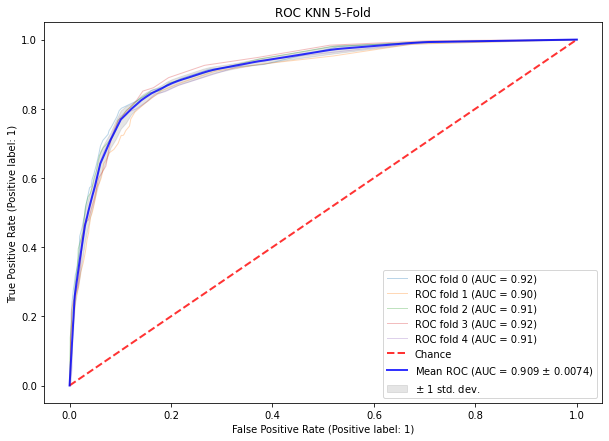

In [164]:
mean_tpr_knn,mean_fpr_knn = plot_roc_kfold(knn_opt ,cv,X,y,feat, "ROC KNN 5-Fold")

Sanity check to make sure we don't suffer from overfitting even after the dimension reduction.

In [165]:
print(f'Mean K-Fold Roc Auc score for our final model on the TRAIN: {best_score_knn}')
auc_score = roc_auc_score(t, knn_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score))


Mean K-Fold Roc Auc score for our final model on the TRAIN: 0.9097642293291928
ROC AUC score of our simulated 'TEST' set: 0.9044186623992936


Looks great and removes any suspicion about overfitting. <br>
We believe this might be the right balance of bias and variance.


Next model:
### Logistic Regression
A linear model that classifies discrete classes based on the fitted weights.

In order to be certain about the picks of hyper-parameters, we grid-search for the best ones with the features that were selected.

In [166]:
parameters = {'penalty':['l1','l2'], 'C': [0.001,0.01,0.1,1]}
lr = LogisticRegression(random_state=42, solver='liblinear',n_jobs=(n_cpu-1))
gscv_lr = GridSearchCV(lr, parameters, scoring='roc_auc',cv=cv,n_jobs=(n_cpu-1))
gscv_lr.fit(X[feat], y)
lr_opt = gscv_lr.best_estimator_


In [167]:
best_params_lr_final = gscv_lr.best_params_
best_score_lr = gscv_lr.best_score_
print(f'Best Params: {best_params_lr_final} \n')


Best Params: {'C': 0.1, 'penalty': 'l1'} 



In [168]:
print(f'Mean K-Fold Roc Auc score for our final model on the TRAIN: {best_score_lr}')


Mean K-Fold Roc Auc score for our final model on the TRAIN: 0.9082094623942153


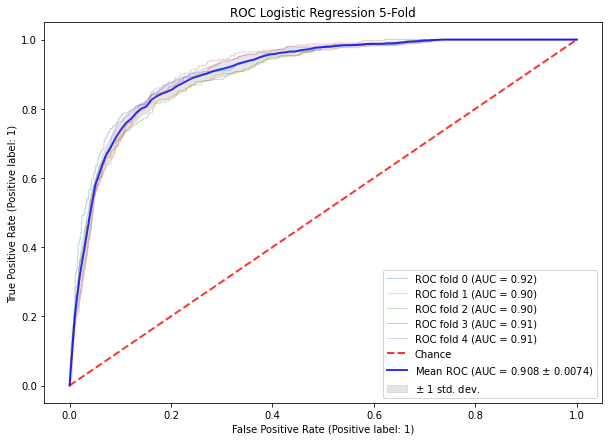

In [169]:
mean_tpr_lr,mean_fpr_lr = plot_roc_kfold(lr_opt,cv,X,y,feat, "ROC Logistic Regression 5-Fold")

Looks like the standard deviation between the folds is very low - another indicator for the model not being overly fitted to just one dataset.

Sanity check to make sure we don't suffer from overfitting even after the dimension reduction.

In [170]:
print(f'Mean K-Fold Roc Auc score for our final model on the TRAIN: {best_score_lr}')
lr_opt.fit(X[feat], y)
auc_score = roc_auc_score(t, lr_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score))


Mean K-Fold Roc Auc score for our final model on the TRAIN: 0.9082094623942153
ROC AUC score of our simulated 'TEST' set: 0.903466780708531


## Advanced Models

After tinkering with all of the options, we decided to go with Multi-Layer Perceptron and RandomForest

First,
### Multi-Layer Perceptron <br>
We want to reduce dimensionality and for that purpose we need to test different parameters to optimize the model that will help us to select our golden number of features.<br> We achieved best score with 30 features but due to time restrictions we will use the features that were selected above in Random Forest.

The GridSearchCV function helps us decide what combination of hyper-parameters will be the best for the model, while cross validating. 

There is a Bias-Variance tradeoff to be considered when selecting the Hyper-parameters such as hidden layers size. We will try to avoid high variance by limiting the size up to 70 and selecting the best value underneath.

In [171]:
parameters = {'hidden_layer_sizes':[30,50,70], 'learning_rate_init':[0.01,0.001], 'learning_rate':['adaptive'],
                'alpha':[0.001,0.01], 'activation':['logistic','relu'], 'solver':['adam']}
mlp = MLPClassifier(random_state=42)
gscv_mlp = GridSearchCV(mlp, parameters, scoring='roc_auc',cv=2, n_jobs=(n_cpu-1))
gscv_mlp.fit(X[feat], y)
mlp_opt = gscv_mlp.best_estimator_


In [172]:
best_params_mlp = gscv_mlp.best_params_
best_score_mlp = gscv_mlp.best_score_
print(f'Best Params: {best_params_mlp} \n')
print(f'Train AUC score for best params: {gscv_mlp.best_score_}')

Best Params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'} 

Train AUC score for best params: 0.9305003622290013


We want to make sure our model doesn't suffer from high variance. <br> 
In order to do that we will train it on our train data and check how the scores varies between the train and the test. <br>
If we will see unusual results we will suspect over-fitting and redo the process again after taking that under consideration.

In [173]:
print(f'Mean K-Fold Roc Auc score for our final model on the TRAIN: {best_score_mlp}')
auc_score_mlp = roc_auc_score(t, mlp_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score_mlp))

Mean K-Fold Roc Auc score for our final model on the TRAIN: 0.9305003622290013
ROC AUC score of our simulated 'TEST' set: 0.9328785454144134


Another fine tuning on the hidden layers:

In [174]:
train_aucs = []
val_aucs = []
layers = list(range(10,85,5))
for layer in layers:
    best_params_mlp['hidden_layer_sizes'] = layer
    mlp_compare = MLPClassifier(random_state=42, **best_params_mlp )
    mlp_compare.fit(X[feat],y)
    auc_train = roc_auc_score(y, mlp_compare.predict_proba(X[feat])[:,1])
    auc_val = roc_auc_score(t, mlp_compare.predict_proba(Z[feat])[:,1])

    train_aucs.append(auc_train)
    val_aucs.append(auc_val)
best_layer = layers[(np.array(val_aucs).argmax())]

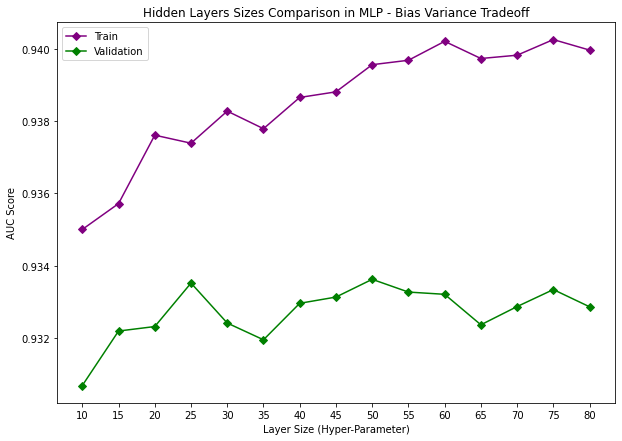

Train:
Best Performing Size of Hidden Layers: 75
AUC Score: 0.94025
Validation:
Best Performing Size of Hidden Layers: 50
AUC Score: 0.93363


In [175]:
plt.figure(figsize=(10,7))
plt.plot(layers, train_aucs, label="Train", marker = 'D', color='purple')
plt.plot(layers, val_aucs, label="Validation", marker = 'D',color='green')
plt.xlabel("Layer Size (Hyper-Parameter)")
plt.ylabel("AUC Score")
plt.xticks(layers)
plt.legend()
plt.title("Hidden Layers Sizes Comparison in MLP - Bias Variance Tradeoff")
plt.show()

print("Train:")
print("Best Performing Size of Hidden Layers: %d" % layers[(np.array(train_aucs).argmax())])
print("AUC Score: %0.5f" % (np.array(train_aucs).max()))


print("Validation:")
print("Best Performing Size of Hidden Layers: %d" % best_layer)
print("AUC Score: %0.5f" % (np.array(val_aucs).max()))

The GridSearch we ran chose 70 for layer size, which seemed quite excessive. <br>
We ran another test to see if we find a better local maximum within the range 10-80 but most of them produced same results and we like the fact that we produce same results with much lesser layers so we will stick to 50 that gave us. 

After optimizing our MLP model we will define it with our best hyper-parameters and features that we found. <br>
Our final MLP model is:

In [176]:
best_params_mlp['hidden_layer_sizes'] = best_layer 
mlp_opt = MLPClassifier(random_state=42, **best_params_mlp )
mlp_opt.fit(X[feat], y)
auc_score_mlp_opt =  roc_auc_score(t, mlp_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score_mlp_opt))


ROC AUC score of our simulated 'TEST' set: 0.9336303939962477


Plot that presents the ROC curve for each fold in our cross-validation and the mean score for all of them.

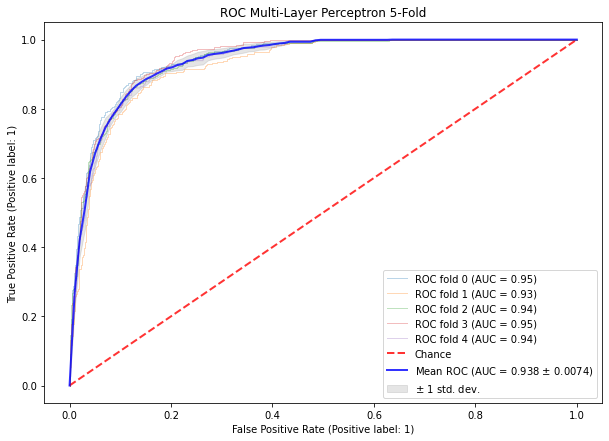

In [177]:
mean_tpr_mlp,mean_fpr_mlp = plot_roc_kfold(mlp_opt,cv,X,y,feat, "ROC Multi-Layer Perceptron 5-Fold")

With 0.94 on the train and 0.934 on the simulated test we will move forward and try the RandomForest model, which is supposed to work great with tabular data.<br>
High hopes for that one!

### Random Forest 

Here, there will be different Hyper-parameters to consider with different specifications that will affect the Bias-Variance tradeoff. <br>
The number of estimators affect this tradeoff. Higher values cause a reduction of the variance. <br>
With the increase of number estimators the max depth can increase as well. <br>
We will try different criterions as well.

In [178]:
parameters = {'n_estimators':[400,800], 'max_depth':[10,15],'min_samples_leaf':[5,8],'criterion':['gini','entropy'] }
rf = RandomForestClassifier(random_state=42)
gscv_rf = GridSearchCV(rf, parameters, scoring='roc_auc',cv=cv, n_jobs=(n_cpu-1))
gscv_rf.fit(X[feat], y)
rf_opt = gscv_rf.best_estimator_

In [179]:
best_params_rf = gscv_rf.best_params_
best_score_rf = gscv_rf.best_score_
print(f'Best Params: {best_params_rf} \n')


Best Params: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 800} 



In [180]:
print(f'Mean K-Fold Roc Auc score for our final model on the TRAIN: {best_score_rf}')
auc_score_rf = roc_auc_score(t, rf_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score_rf))


Mean K-Fold Roc Auc score for our final model on the TRAIN: 0.9424451003539106
ROC AUC score of our simulated 'TEST' set: 0.9335200309016665


We will make fine tuning on max_depth values again in order to optimize it Bias-Variance wise. This will be our FINAL MODEL  

In [181]:
train_aucs = []
val_aucs = []
depths = list(range(8,21))
for d in depths:
    best_params_rf['max_depth'] = d 
    rf_compare = RandomForestClassifier(random_state=42,**best_params_rf)
    rf_compare.fit(X[feat],y)
    auc_train = roc_auc_score(y, rf_compare.predict_proba(X[feat])[:,1])
    auc_val = roc_auc_score(t, rf_compare.predict_proba(Z[feat])[:,1])
    train_aucs.append(auc_train)
    val_aucs.append(auc_val)

best_depth = depths[(np.array(val_aucs).argmax())]


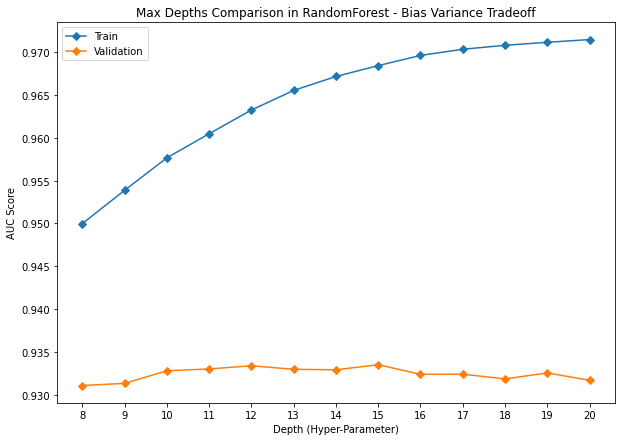

Train:
Best Performing Depth: 20
AUC Score: 0.97147
Validation:
Best Performing Depth: 15
ROC AUC Score: 0.93352


In [182]:
plt.figure(figsize=(10,7))
plt.plot(depths, train_aucs, label="Train", marker = 'D')
plt.plot(depths, val_aucs, label="Validation", marker = 'D')
plt.xlabel("Depth (Hyper-Parameter)")
plt.ylabel("AUC Score")
plt.xticks(depths)
plt.legend()
plt.title("Max Depths Comparison in RandomForest - Bias Variance Tradeoff")
plt.show()

print("Train:")
print("Best Performing Depth: %d" % depths[(np.array(train_aucs).argmax())])
print("AUC Score: %0.5f" % (np.array(train_aucs).max()))

print("Validation:")
print("Best Performing Depth: %d" % best_depth)
print("ROC AUC Score: %0.5f" % (np.array(val_aucs).max()))

We notice that there is a big difference between the results of the train and the 'test'. <br>
When considering Bias-Variance tradeoff we suspect that we use too many features.

In [183]:
best_params_rf['max_depth'] = best_depth 
rf_opt = RandomForestClassifier(random_state=42, **best_params_rf)
rf_opt.fit(X[feat], y)
auc_score_rf_opt =  roc_auc_score(t, rf_opt.predict_proba(Z[feat])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score_rf_opt))


ROC AUC score of our simulated 'TEST' set: 0.9335200309016665


After recieving good results we want to get insights on our features. <br>
Therefore, we plot our feature importance to see how each and every one of them affect the results. <br>
With that plot we will decide whether we need to reduce the ammount of features or to stick with what we accomplished.

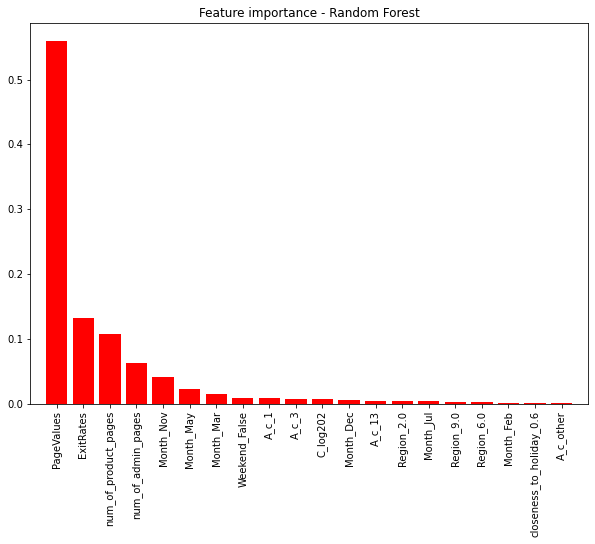

In [184]:
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.title('Feature importance - Random Forest')
plt.bar(range(X[feat].shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X[feat].shape[1]), X[feat].columns[indices], rotation='vertical')
plt.xlim([-1, X[feat].shape[1]])
plt.show()

It is strikingly amazing how important 'PageValues' is to our model. 

In addition, it is clear that we have some features with minimal contribution. <br>
Removing some of them might prove useful to us. Using the plot, we made a decision to move forward with only the 15 best features in this model.

In [185]:
feat_opt = feat[indices][0:15]
feat_opt 


array(['PageValues', 'ExitRates', 'num_of_product_pages',
       'num_of_admin_pages', 'Month_Nov', 'Month_May', 'Month_Mar',
       'Weekend_False', 'A_c_1', 'A_c_3', 'C_log202', 'Month_Dec',
       'A_c_13', 'Region_2.0', 'Month_Jul'], dtype=object)

In [186]:
train_aucs = []
val_aucs = []
depths = list(range(8,21))
for d in depths:
    best_params_rf['max_depth'] = d 
    rf_compare = RandomForestClassifier(random_state=42,**best_params_rf)
    rf_compare.fit(X[feat_opt],y)
    auc_train = roc_auc_score(y, rf_compare.predict_proba(X[feat_opt])[:,1])
    auc_val = roc_auc_score(t, rf_compare.predict_proba(Z[feat_opt])[:,1])
    train_aucs.append(auc_train)
    val_aucs.append(auc_val)

best_depth = depths[(np.array(val_aucs).argmax())]


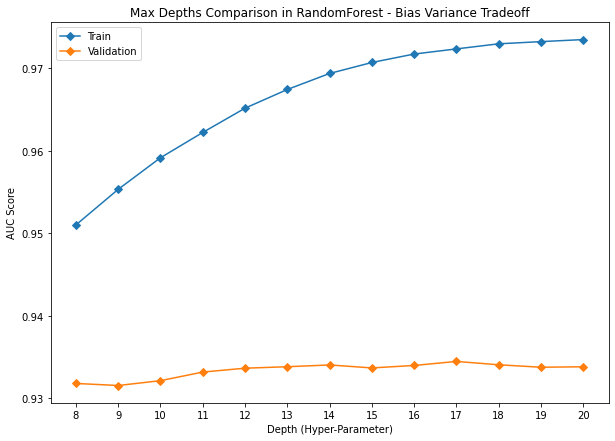

Train:
Best Performing Depth: 20
AUC Score: 0.97349
Validation:
Best Performing Depth: 17
ROC AUC Score: 0.93448


In [187]:
plt.figure(figsize=(10,7))
plt.plot(depths, train_aucs, label="Train", marker = 'D')
plt.plot(depths, val_aucs, label="Validation", marker = 'D')
plt.xlabel("Depth (Hyper-Parameter)")
plt.ylabel("AUC Score")
plt.xticks(depths)
plt.legend()
plt.title("Max Depths Comparison in RandomForest - Bias Variance Tradeoff")
plt.show()

print("Train:")
print("Best Performing Depth: %d" % depths[(np.array(train_aucs).argmax())])
print("AUC Score: %0.5f" % (np.array(train_aucs).max()))

print("Validation:")
print("Best Performing Depth: %d" % best_depth)
print("ROC AUC Score: %0.5f" % (np.array(val_aucs).max()))

In [188]:
best_params_rf['max_depth'] = best_depth 
rf_opt = RandomForestClassifier(random_state=42, **best_params_rf)
rf_opt.fit(X[feat_opt], y)
auc_score_rf_opt =  roc_auc_score(t, rf_opt.predict_proba(Z[feat_opt])[:,1])
print("ROC AUC score of our simulated 'TEST' set: "+str(auc_score_rf_opt))


ROC AUC score of our simulated 'TEST' set: 0.9344788102858405


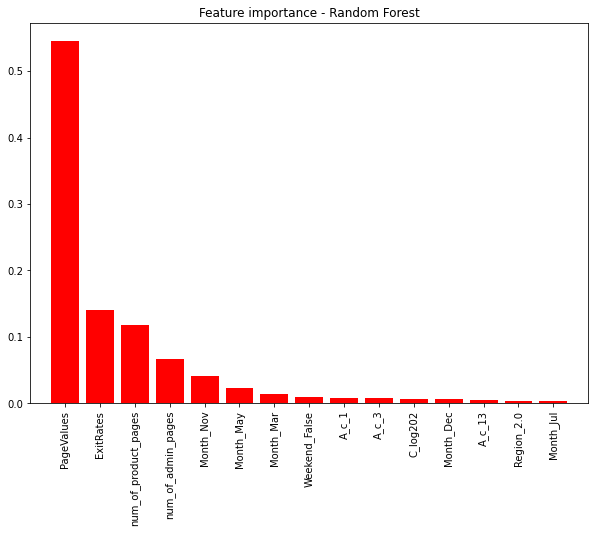

In [189]:
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.title('Feature importance - Random Forest')
plt.bar(range(X[feat_opt].shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X[feat_opt].shape[1]), X[feat_opt].columns[indices], rotation='vertical')
plt.xlim([-1, X[feat_opt].shape[1]])
plt.show()

Plot that presents the ROC curve for each fold in our cross-validation and the mean score for all of them.

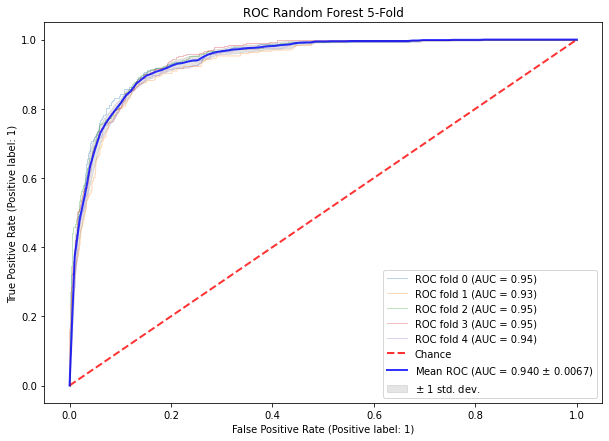

In [190]:
mean_tpr_rf,mean_fpr_rf = plot_roc_kfold(rf_opt,cv,X,y,feat_opt,"ROC Random Forest 5-Fold")

Lets move on and examine **Confusion Matrices**

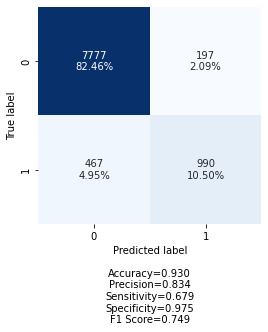

In [191]:
rf_preds_train = (rf_opt.predict_proba(X[feat_opt])[:,1]>=0.5).astype(int)
cf_matrix = confusion_matrix(y, rf_preds_train)
make_confusion_matrix(cf_matrix, figsize=(4,4), cbar=False)


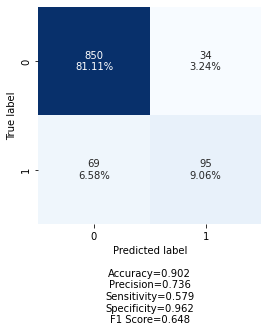

In [192]:
rf_preds = (rf_opt.predict_proba(Z[feat_opt])[:,1]>=0.5).astype(int)
cf_matrix = confusion_matrix(t, rf_preds)
make_confusion_matrix(cf_matrix, figsize=(4,4), cbar=False)

On average 90 out of 100 labels are correct. <br>
On average ~74 out of 100 labeled subjects by our model are ended with purchase. <br>
On average ~58 out of 100 purhcases that been made are labeled as completed purchases. <br>
On average 96 out of 100 sessions that ended without purchase are correctly labeled as non purchase sessions.

When using different thresholds, the metrics we can extract from the confusion matrix may vary. <br>
We tried looking on a matrix with a threshold of 0.4 and elaborated more in the report.

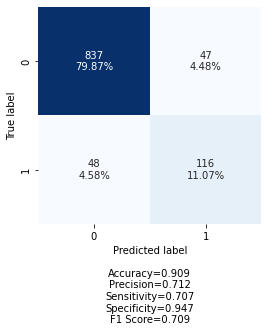

In [193]:
rf_preds = (rf_opt.predict_proba(Z[feat_opt])[:,1]>=0.4).astype(int)
cf_matrix = confusion_matrix(t, rf_preds)
make_confusion_matrix(cf_matrix, figsize=(4,4), cbar=False)

Let's look at all of our models on the same plot

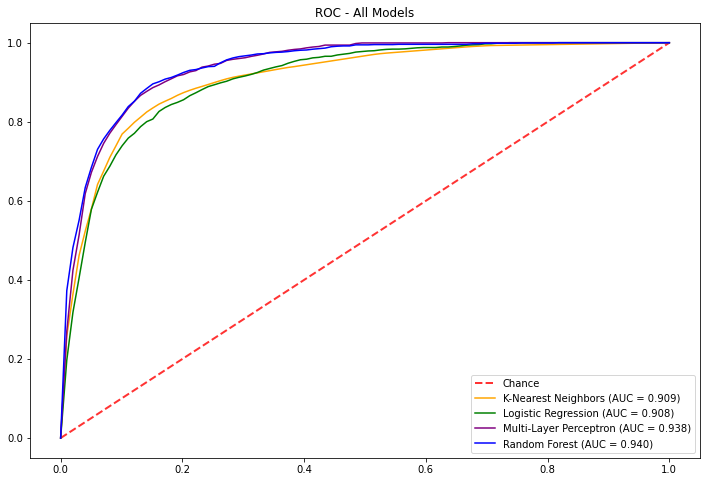

In [194]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(mean_fpr_knn, mean_tpr_knn, color="orange", label= 'K-Nearest Neighbors (AUC = %0.3f)' % auc(mean_fpr_knn,mean_tpr_knn))
ax.plot(mean_fpr_lr, mean_tpr_lr, color="green", label= 'Logistic Regression (AUC = %0.3f)' % auc(mean_fpr_lr,mean_tpr_lr))
ax.plot(mean_fpr_mlp, mean_tpr_mlp, color="purple", label= 'Multi-Layer Perceptron (AUC = %0.3f)' % auc(mean_fpr_mlp,mean_tpr_mlp))
ax.plot(mean_fpr_rf, mean_tpr_rf, color="blue", label= 'Random Forest (AUC = %0.3f)' % auc(mean_fpr_rf,mean_tpr_rf))
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC - All Models",
)
ax.legend(loc="lower right")
plt.show()

When comparing all scores of our models, Random Forest Perform the best.

# Prediction on Test Data

We will use the predictions that the pipeline produces after learning with all the data that we posses.

In [195]:
# predictions = rf_opt.predict_proba(test[feat_opt])[:,1]
# predictions = pd.DataFrame(predictions)
# predictions.index.names = ['id']
# predictions.rename(columns={0:'predict_prob'}, inplace=True)
# predictions.to_csv('Submission_group_40_reg.csv')


# PIPELINE - FINAL MODEL (RANDOM FOREST)

We created a one-click function that will produce the file of the predictions probability on the test. 

In order to use the pipline, please run the following cells using 'Execute cell and below'. <br>
The two minimized cells conatin all the imports and functions we used and the implementation of our PIPELINE.

In [196]:
#########################################################################################################
# Click 'Execute cell and below' here ------------------------------------------------------------------>
#########################################################################################################  

In [197]:
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import auc, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


#Functions:
def sum_up_durations(chosen_duration, df): 
    # Sum up durations with only one NA in durations because they need to be added up to the same value
    duration_lst = ['total_duration' , 'admin_page_duration' , 'info_page_duration' , 'product_page_duration']
    duration_lst.remove(chosen_duration)
    mask = ((df[chosen_duration].isna()) & (df[duration_lst[0]].notna()) & (df[duration_lst[1]].notna()) & (df[duration_lst[2]].notna()))
    if (chosen_duration == 'total_duration'):
        df.loc[mask, chosen_duration] = df[mask][duration_lst].sum(axis=1)
    else :
        df.loc[mask, chosen_duration] = df[mask]['total_duration'] - df[mask][duration_lst[1:]].sum(axis=1)
        
def fill_na_duration_by_pages(chosen_duration, chosen_page, df_source,df_target):
    # Fill NA of durations using the median of each duration for a specific page
    mask = df_target[chosen_duration].isna()
    x = np.array(df_source[chosen_page])
    x = x[~np.isnan(x)]
    x = list(set(x))
    for elem in x:
        df_target.loc[mask & (df_target[chosen_page] == elem), chosen_duration] = np.nanmedian(df_source[(df_source[chosen_page] == elem)][chosen_duration])

def fill_na_pages_by_duration(chosen_duration, chosen_page, df_source, df_target):
    # Fill NA of pages using manipulation on the median of each duration for a specific page
    sub = df_source[(df_source[chosen_page].notna()) & (df_source[chosen_page] != 0) \
    & (df_source[chosen_duration].notna()) & (df_source[chosen_duration] != 0)] 
    avg_page = sub[chosen_duration] / sub[chosen_page]
    median_page = np.median(avg_page)
    df_target.loc[(df_target[chosen_page].isna()) & (df_target[chosen_duration].notna()), chosen_page] = np.ceil(df_target[chosen_duration] / median_page)

def outliers_handling(feature,p, df_source, df_target):
    # Replacing outliers value using specified percentile
    values = np.array(df_source[feature])
    threshold = np.percentile(values, q= p)
    print("The number of values that has changed: ", len(df_target[df_target[feature] > threshold]))
    df_target.loc[df_target[feature] > threshold, feature] = threshold

def scores_over_lambda(Cs,scores,chosen_c):
    # Plot scores of the model over hyperparameter and extract the best one
    plt.plot(Cs, scores)
    plt.xlabel('Cs')
    plt.ylabel('accuracy score')
    plt.title("accuracy measure over different lambda's")
    plt.show()
    C_opt_lr = chosen_c
    lambda_opt_lr = 1/chosen_c
    print("The optimal lambda is: ",lambda_opt_lr,
    "\n( Best C:", C_opt_lr, ")")
    return C_opt_lr, lambda_opt_lr

def normalize_columns(col,data):
    # Normalize given columns between 0 - 1 relative to the origin
    # Given the data and a list of columns
    for c in col:
        sum = data[c].sum(axis=0)
        data[c] = data[c].divide(sum, axis=0)

def plot_roc_kfold(clf,cv,X,y,feat,giventitle):
    # Plot roc curve for each k of the folds given in the cv argument
    # Returns the mean tpr and fpr for comparison purposes
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10,7))
    for i, (train, test) in enumerate(cv.split(X[feat], y)):
        clf.fit(X[feat].iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            clf,
            X[feat].iloc[test],
            y.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.3f $\pm$ %0.4f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=giventitle,
    )

    ax.legend(loc="lower right")
    plt.show()

    return mean_tpr, mean_fpr


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            sensitivity    = cf[1,1] / sum(cf[1,:])
            specificity = cf[0,0] / sum(cf[0,:])
            f1_score  = 2*precision*sensitivity / (precision + sensitivity)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nSensitivity={:0.3f}\nSpecificity={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,sensitivity,specificity,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    
    

In [198]:
def pipeline(train_file, test_file) -> None:
    '''
    Creates predictions csv file on a given test after training a model on a given dataset.
    train_file: String. The name of the data file in the current directory
    test_file: String. The name of the test file in the current directory
    '''

    # DATA
    
    data = pd.read_csv(train_file)

    data["info_page_duration"] = data["info_page_duration"].replace("minutes", "", regex=True).astype("float64")
    data["product_page_duration"] = data["product_page_duration"].replace("minutes", "", regex=True).astype("float64")

    data["admin_page_duration"] = np.where(data["num_of_admin_pages"] == 0, 0, data.admin_page_duration)
    data["num_of_admin_pages"] = np.where(data["admin_page_duration"] == 0, 0, data.num_of_admin_pages)

    data["info_page_duration"] = np.where(data["num_of_info_pages"] == 0, 0, data.info_page_duration)
    data["num_of_info_pages"] = np.where(data["info_page_duration"] == 0, 0, data.num_of_info_pages)

    data["product_page_duration"] = np.where(data["num_of_product_pages"] == 0, 0, data.product_page_duration)
    data["num_of_product_pages"] = np.where(data["product_page_duration"] == 0, 0, data.num_of_product_pages)

    data.loc[data['total_duration'] == 0 , ['admin_page_duration','num_of_admin_pages','info_page_duration',\
        'num_of_info_pages','product_page_duration','num_of_product_pages']] = 0

    sum_up_durations('admin_page_duration',data)
    sum_up_durations('info_page_duration',data)
    sum_up_durations('product_page_duration',data)
    sum_up_durations('total_duration',data)

    fill_na_duration_by_pages('admin_page_duration','num_of_admin_pages',data,data)
    fill_na_duration_by_pages('info_page_duration','num_of_info_pages',data,data)
    fill_na_duration_by_pages('product_page_duration','num_of_product_pages',data,data)

    fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,data)
    fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,data)
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)

    sum_up_durations('admin_page_duration',data)
    sum_up_durations('info_page_duration',data)
    sum_up_durations('product_page_duration',data)
    sum_up_durations('total_duration',data)

    fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,data)
    fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,data)
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)

    data.loc[(data['admin_page_duration'].isna()),'admin_page_duration'] = 0
    data.loc[(data['num_of_admin_pages'].isna()),'num_of_admin_pages'] = 0
    data.loc[(data['info_page_duration'].isna()),'info_page_duration'] = 0
    data.loc[(data['num_of_info_pages'].isna()),'num_of_info_pages'] = 0
    data.loc[data['product_page_duration'].isna(), 'product_page_duration'] = np.nanmedian(data['product_page_duration'])
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,data)

    sum_up_durations('total_duration',data)

    data.loc[data["info_page_duration"] < 0, "info_page_duration"] = 0
    data[data["info_page_duration"] < 0]

    data.loc[(data['total_duration'] == 0) & data['BounceRates'].isna(), 'BounceRates'] = 0.2
    data.loc[(data['total_duration'] == 0) & data['ExitRates'].isna(), 'ExitRates'] = 0.2

    data.loc[data['BounceRates'].isna() ,'BounceRates'] = 0
    data.loc[data['ExitRates'].isna() ,'ExitRates'] = np.nanmedian(data['ExitRates'])

    data.loc[data['PageValues'].isna() ,'PageValues'] = np.mean(data['PageValues'])

    mask_isna_holiday = data['closeness_to_holiday'].isna()
    month_holiday = np.array(data['Month'])
    month_holiday = month_holiday[~pd.isna(month_holiday)]
    month_holiday = list(set(month_holiday))
    for m in month_holiday:
        data.loc[mask_isna_holiday & (data['Month'] == m), "closeness_to_holiday"] = np.nanmedian(data[(data['Month'] == m)]["closeness_to_holiday"])
    data.loc[mask_isna_holiday, "closeness_to_holiday"] = np.nanmedian(data["closeness_to_holiday"])

    data['Month'].fillna(data['Month'].value_counts().index[0], inplace=True)

    data.loc[(data['internet_browser'].str.startswith('chrome')) & (data['internet_browser'].notnull()), "internet_browser"] = 'chrome'
    data.loc[(data['internet_browser'].str.startswith('safari')) & (data['internet_browser'].notnull()), "internet_browser"] = 'safari'
    data.loc[(data['internet_browser'].str.startswith('browser')) & (data['internet_browser'].notnull()), "internet_browser"] = 'browser'
    data.loc[(data['internet_browser'].str.startswith('edge')) & (data['internet_browser'].notnull()), "internet_browser"] = 'edge'

    mask_isna_browser = data['internet_browser'].isna()
    devices = np.array(data['device'])
    devices = devices[~pd.isna(devices)]
    devices = list(set(devices))
    for d in devices:
        data.loc[mask_isna_browser & (data['device'] == d), "internet_browser"] = data[data['device'] == d]['internet_browser'].value_counts().index[0]

    mask_isna_device = data['device'].isna()
    browsers = np.array(data['internet_browser'])
    browsers = browsers[~pd.isna(browsers)]
    browsers = list(set(browsers))
    for b in browsers:
        data.loc[mask_isna_device & (data['internet_browser'] == b), "device"] = data[data['internet_browser'] == b]['device'].value_counts().index[0]
    data['device'].isna().sum()

    data.loc[mask_isna_device , "device"] = data['device'].value_counts().index[0]
    data.loc[mask_isna_browser , "internet_browser"] = data['internet_browser'].value_counts().index[0]

    mask_isna_region = data['Region'].isna()
    for d in devices:
        data.loc[mask_isna_region & (data['device'] == d), "Region"] = data[data['device'] == d]['Region'].value_counts().index[0]

    print(data['user_type'].value_counts())
    data.loc[data['user_type'].isna(), "user_type"] = 'Returning_Visitor'

    print(data['Weekend'].value_counts())
    data.loc[data['Weekend'].isna(), "Weekend"] = False

    data.loc[(data['A'].str.startswith('c_20')) & (data['A'].notnull()), "A"] = 'c_20'

    data['A'].fillna(data['A'].value_counts().index[0], inplace=True)

    np.random.seed(0)
    mask_B_na = data['B'].isna()
    rand_B = np.random.normal(loc=100,scale=10,size=len(data[mask_B_na]))
    data.loc[mask_B_na , "B"] = rand_B

    mask_C_na = data['C'].isna()
    C_logs = data['C'].dropna().unique()
    C_rand = []
    for i in range(mask_C_na.sum()):
        C_rand.append(C_logs[np.random.randint(6)]) 
    data.loc[mask_C_na , "C"] = C_rand

    imputer = KNNImputer(n_neighbors=15)
    imputer.fit(data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
                "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]])
    numeric_data = pd.DataFrame(imputer.transform(data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
                "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]]))
    numeric_data.columns = data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
                "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]].columns

    data.drop(labels=['D'],axis=1,inplace=True)
    data['D'] = numeric_data['D']

    b_prob = plt.boxplot('B',data=data)
    b_lst = [item.get_ydata()[1] for item in b_prob['whiskers']]
    data.loc[data['B'] > b_lst[1], "B"] = b_lst[1]
    data.loc[data['B'] < b_lst[0], "B"] = b_lst[0]

    outliers_handling('admin_page_duration', 99.5 ,data,data)
    outliers_handling('info_page_duration', 99.5 ,data,data)
    outliers_handling('product_page_duration', 99.5 ,data,data)
    outliers_handling('total_duration', 99.2 ,data,data)
    outliers_handling('num_of_admin_pages', 99.2 ,data,data)
    outliers_handling('num_of_info_pages', 99.2 ,data,data)
    outliers_handling('num_of_product_pages', 99.5 ,data,data)

    val_cnt = data['A'].value_counts()
    c_others = list(val_cnt[val_cnt<len(data)*0.01].index)

    for c in c_others:
        data.loc[data['A'] == c, 'A'] = 'c_other'

    #TEST

    test = pd.read_csv(test_file)

    test["info_page_duration"] = test["info_page_duration"].replace("minutes", "", regex=True).astype("float64")
    test["product_page_duration"] = test["product_page_duration"].replace("minutes", "", regex=True).astype("float64")

    test["admin_page_duration"] = np.where(test["num_of_admin_pages"] == 0, 0, test.admin_page_duration)
    test["num_of_admin_pages"] = np.where(test["admin_page_duration"] == 0, 0, test.num_of_admin_pages)

    test["info_page_duration"] = np.where(test["num_of_info_pages"] == 0, 0, test.info_page_duration)
    test["num_of_info_pages"] = np.where(test["info_page_duration"] == 0, 0, test.num_of_info_pages)

    test["product_page_duration"] = np.where(test["num_of_product_pages"] == 0, 0, test.product_page_duration)
    test["num_of_product_pages"] = np.where(test["product_page_duration"] == 0, 0, test.num_of_product_pages)

    test.loc[test['total_duration'] == 0 , ['admin_page_duration','num_of_admin_pages','info_page_duration',\
        'num_of_info_pages','product_page_duration','num_of_product_pages']] = 0

    sum_up_durations('admin_page_duration',test)
    sum_up_durations('info_page_duration',test)
    sum_up_durations('product_page_duration',test)
    sum_up_durations('total_duration',test)

    fill_na_duration_by_pages('admin_page_duration','num_of_admin_pages',data,test)
    fill_na_duration_by_pages('info_page_duration','num_of_info_pages',data,test)
    fill_na_duration_by_pages('product_page_duration','num_of_product_pages',data,test)

    fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test)
    fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test)
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)

    sum_up_durations('admin_page_duration',test)
    sum_up_durations('info_page_duration',test)
    sum_up_durations('product_page_duration',test)
    sum_up_durations('total_duration',test)

    fill_na_pages_by_duration('admin_page_duration','num_of_admin_pages',data,test)
    fill_na_pages_by_duration('info_page_duration','num_of_info_pages',data,test)
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)

    test.loc[(test['admin_page_duration'].isna()),'admin_page_duration'] = 0
    test.loc[(test['num_of_admin_pages'].isna()),'num_of_admin_pages'] = 0
    test.loc[(test['info_page_duration'].isna()),'info_page_duration'] = 0
    test.loc[(test['num_of_info_pages'].isna()),'num_of_info_pages'] = 0
    test.loc[test['product_page_duration'].isna(), 'product_page_duration'] = np.nanmedian(data['product_page_duration'])
    fill_na_pages_by_duration('product_page_duration','num_of_product_pages',data,test)

    sum_up_durations('total_duration',test)

    test.loc[test["info_page_duration"] < 0, "info_page_duration"] = 0

    test.loc[(test['total_duration'] == 0) & test['BounceRates'].isna(), 'BounceRates'] = 0.2
    test.loc[(test['total_duration'] == 0) & test['ExitRates'].isna(), 'ExitRates'] = 0.2

    test.loc[test['BounceRates'].isna() ,'BounceRates'] = 0
    test.loc[test['ExitRates'].isna() ,'ExitRates'] = np.nanmedian(data['ExitRates'])

    test.loc[test['PageValues'].isna() ,'PageValues'] = np.mean(data['PageValues'])

    mask_isna_holiday = test['closeness_to_holiday'].isna()
    month_holiday = np.array(test['Month'])
    month_holiday = month_holiday[~pd.isna(month_holiday)]
    month_holiday = list(set(month_holiday))
    for m in month_holiday:
        test.loc[mask_isna_holiday & (test['Month'] == m), "closeness_to_holiday"] = np.nanmedian(data[(data['Month'] == m)]["closeness_to_holiday"])

    test.loc[mask_isna_holiday, "closeness_to_holiday"] = np.nanmedian(data["closeness_to_holiday"])

    test['Month'].fillna(data['Month'].value_counts().index[0], inplace=True)

    test.loc[(test['internet_browser'].str.startswith('chrome')) & (test['internet_browser'].notnull()), "internet_browser"] = 'chrome'
    test.loc[(test['internet_browser'].str.startswith('safari')) & (test['internet_browser'].notnull()), "internet_browser"] = 'safari'
    test.loc[(test['internet_browser'].str.startswith('browser')) & (test['internet_browser'].notnull()), "internet_browser"] = 'browser'
    test.loc[(test['internet_browser'].str.startswith('edge')) & (test['internet_browser'].notnull()), "internet_browser"] = 'edge'

    mask_isna_browser = test['internet_browser'].isna()
    devices = np.array(test['device'])
    devices = devices[~pd.isna(devices)]
    devices = list(set(devices))
    for d in devices:
        test.loc[mask_isna_browser & (test['device'] == d), "internet_browser"] = data[data['device'] == d]['internet_browser'].value_counts().index[0]
        
    mask_isna_device = test['device'].isna()
    browsers = np.array(test['internet_browser'])
    browsers = browsers[~pd.isna(browsers)]
    browsers = list(set(browsers))
    for b in browsers:
        test.loc[mask_isna_device & (test['internet_browser'] == b), "device"] = data[data['internet_browser'] == b]['device'].value_counts().index[0]

    test.loc[mask_isna_device , "device"] = data['device'].value_counts().index[0]
    test.loc[mask_isna_browser , "internet_browser"] = data['internet_browser'].value_counts().index[0]

    mask_isna_region = test['Region'].isna()
    for d in devices:
        test.loc[mask_isna_region & (test['device'] == d), "Region"] = data[data['device'] == d]['Region'].value_counts().index[0]

    test.loc[test['user_type'].isna(), "user_type"] = 'Returning_Visitor'

    test.loc[test['Weekend'].isna(), "Weekend"] = False

    test.loc[(test['A'].str.startswith('c_20')) & (test['A'].notnull()), "A"] = 'c_20'

    test['A'].fillna(data['A'].value_counts().index[0], inplace=True)

    np.random.seed(0)
    mask_B_na = test['B'].isna()
    rand_B = np.random.normal(loc=100,scale=10,size=len(test[mask_B_na]))
    test.loc[mask_B_na , "B"] = rand_B

    mask_C_na = test['C'].isna()
    C_logs = data['C'].dropna().unique()
    C_rand = []
    for i in range(mask_C_na.sum()):
        C_rand.append(C_logs[np.random.randint(6)]) 
    test.loc[mask_C_na , "C"] = C_rand

    numeric_test = pd.DataFrame(imputer.transform(test[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
                "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]]))
    numeric_test.columns = data[['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',"info_page_duration",
                "num_of_product_pages","num_of_product_pages","total_duration", "BounceRates", "ExitRates","PageValues","B","D"]].columns

    test.drop(labels=['D'],axis=1,inplace=True)
    test['D'] = numeric_test['D']

    for c in c_others:
        test.loc[test['A'] == c, 'A'] = 'c_other'
    test['A'].value_counts()

    data_dummies = pd.get_dummies(data,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])
    data_dummies = data_dummies.drop(labels= ['id','purchase'],axis=1)
    test = pd.get_dummies(test,columns=['closeness_to_holiday','Month','device','internet_browser','Region','user_type','Weekend', 'A','C'])

    columns = list(data_dummies.iloc[:,1:].columns)
    for col in columns:
        if col not in test.columns:
            test[str(col)] = np.zeros(len(test))
            print(col)

    X = data_dummies.copy()
    y = data['purchase']
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    
    n_cpu = os.cpu_count()

    # Random Forest Model:
    # Chosen features with SFS algorithm 
    # Final 15 features
    
    feat =['PageValues', 'ExitRates', 'num_of_product_pages',
       'num_of_admin_pages', 'Month_Nov', 'Month_May', 'Month_Mar',
       'Weekend_False', 'A_c_1', 'A_c_3', 'C_log202', 'Month_Dec',
       'A_c_13', 'Region_2.0', 'Month_Jul']

    parameters = {'n_estimators':800, 'max_depth':17,'min_samples_leaf':5,'criterion':'entropy'}
    rf = RandomForestClassifier(random_state=42, **parameters)
    rf.fit(X[feat], y)
    
    # Predictions

    predictions = rf.predict_proba(test[feat])[:,1]
    predictions = pd.DataFrame(predictions)
    predictions.index.names = ['id']
    predictions.rename(columns={0:'predict_prob'}, inplace=True)
    predictions.to_csv('Submission_group_40.csv')


In [199]:
%%capture
pipeline("train.csv", "test.csv")